# 不動産価格予測モデル検討レポート

## 1. はじめに

本レポートでは、米国の特定地域の不動産売買データを用いて、不動産価格予測モデルを構築・評価する。  
本分析は、将来の同様データに対する価格予測サービスの有用性を評価し、事業化の可否や改善策を検討するための基礎資料となる。  

## 2. データ概要

対象データには以下の変数が含まれる。

- **date**: 売買成立日
- **price**: 売買価格(予測対象)
- **sqft_lot**: 敷地面積
- **sqft_living**: 居住スペース面積
- **grade**: 建築・デザイン品質評価(1～13)
- **lat**: 緯度
- **long**: 経度
- **yr_built**: 建築年
- **yr_renovated**: 最終リノベーション年(0は未リノベーション)

本分析では、`date` と `yr_renovated` をモデル利用可能な特徴量へ変換する。

## 3. 分析環境とパッケージ


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%matplotlib inline
sns.set_style("whitegrid")
pd.options.display.float_format = '{:,.2f}'.format


## 4. データ読み込みと基本確認

`data.csv` を読み込み、`date` を日付型へ変換する。


In [3]:
# データ読み込み
data = pd.read_csv("data.csv", dtype={'date': str})
data['date'] = pd.to_datetime(data['date'], format='%Y%m%d')

# 初期データ確認
display(data.head())
display(data.info())


date   price  sqft_lot  sqft_living  grade   lat    long  yr_built  \
0 2014-10-13  221900      5650         1180      7 47.51 -122.26      1955   
1 2014-12-09  538000      7242         2570      7 47.72 -122.32      1951   
2 2015-02-25  180000     10000          770      6 47.74 -122.23      1933   
3 2014-12-09  604000      5000         1960      7 47.52 -122.39      1965   
4 2015-02-18  510000      8080         1680      8 47.62 -122.05      1987   

   yr_renovated  
0             0  
1          1991  
2             0  
3             0  
4             0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          21613 non-null  datetime64[ns]
 1   price         21613 non-null  int64         
 2   sqft_lot      21613 non-null  int64         
 3   sqft_living   21613 non-null  int64         
 4   grade         21613 non-null  int64         
 5   lat           21613 non-null  float64       
 6   long          21613 non-null  float64       
 7   yr_built      21613 non-null  int64         
 8   yr_renovated  21613 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6)
memory usage: 1.5 MB


None

## 5. 特徴量エンジニアリング

ここで、`date` からの特徴量抽出と `yr_renovated` からの特徴量変換を行う。

- `date` を用いて `year_sold`, `month_sold`, `days_since_2014_01_01` を作成する
- `yr_renovated` を用いて、リノベーション有無フラグ(`renovated_flag`)およびリノベから売却までの経過年数(`years_since_renovation`)を作成する。

その後、統計量を再確認する。

In [4]:
base_date = pd.Timestamp("2014-01-01")
data['year_sold'] = data['date'].dt.year
data['month_sold'] = data['date'].dt.month
data['days_since_2014_01_01'] = (data['date'] - base_date).dt.days + 1

data['renovated_flag'] = (data['yr_renovated'] > 0).astype(int)
data['years_since_renovation'] = np.where(
    data['yr_renovated'] > 0,
    data['year_sold'] - data['yr_renovated'],
    0
)

# モデル用数値カラム
numeric_cols = [
    'price','sqft_lot','sqft_living','grade','lat','long','yr_built',
    'year_sold','month_sold','days_since_2014_01_01','renovated_flag','years_since_renovation'
]

describe_df = data[numeric_cols].describe()

# 表の表記を日本語に変更
describe_df = describe_df.rename(index={
    'count': '件数',
    'mean': '平均',
    'std': '標準偏差',
    'min': '最小',
    '25%': '25%',
    '50%': '中央値',
    '75%': '75%',
    'max': '最大'
})

# カラム名を日本語に変更
describe_df = describe_df.rename(columns={
    'price': '価格',
    'sqft_lot': '敷地面積',
    'sqft_living': '居住スペース面積',
    'grade': '建築・デザイン品質評価',
    'lat': '緯度',
    'long': '経度',
    'yr_built': '建築年',
    'year_sold': '売却年',
    'month_sold': '売却月',
    'days_since_2014_01_01': '2014年1月1日からの日数',
    'renovated_flag': 'リノベーションフラグ',
    'years_since_renovation': 'リノベーションからの経過年数'
})

describe_df = describe_df.applymap(lambda x: f"{x:,.2f}")
display(describe_df)


/var/folders/73/v6765gtj31q04rybrhm_l6xh0000gn/T/ipykernel_7275/1450717754.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  describe_df = describe_df.applymap(lambda x: f"{x:,.2f}")


価格          敷地面積   居住スペース面積 建築・デザイン品質評価         緯度         経度  \
件数       21,613.00     21,613.00  21,613.00   21,613.00  21,613.00  21,613.00   
平均      540,088.14     15,106.97   2,079.90        7.66      47.56    -122.21   
標準偏差    367,127.20     41,420.51     918.44        1.18       0.14       0.14   
最小       75,000.00        520.00     290.00        1.00      47.16    -122.52   
25%     321,950.00      5,040.00   1,427.00        7.00      47.47    -122.33   
中央値     450,000.00      7,618.00   1,910.00        7.00      47.57    -122.23   
75%     645,000.00     10,688.00   2,550.00        8.00      47.68    -122.12   
最大    7,700,000.00  1,651,359.00  13,540.00       13.00      47.78    -121.31   

            建築年        売却年        売却月 2014年1月1日からの日数 リノベーションフラグ リノベーションからの経過年数  
件数    21,613.00  21,613.00  21,613.00      21,613.00  21,613.00      21,613.00  
平均     1,971.01   2,014.32       6.57         302.19       0.04           0.78  
標準偏差      29.37       0.47       3.12         113.05       0.20           4.90  
最小     1,900.00   2,014.00       1.00         122.00       0.00          -1.00  
25%    1,951.00   2,014.00       4.00         203.00       0.00           0.00  
中央値    1,975.00   2,014.00       6.00         289.00       0.00           0.00  
75%    1,997.00   2,015.00       9.00         413.00       0.00           0.00  
最大     2,015.00   2,015.00      12.00         512.00       1.00          80.00

## 5.2 エラーデータの除外とデータ再確認

リノベーションからの経過年数(`years_since_renovation`)が負の値となっているデータは、`yr_renovated` が `year_sold` より後になっているためエラーデータと判断し、除外します。エラーデータを除外した後、再度統計量を表で確認します。


In [5]:
# エラーデータの除外
initial_count = data.shape[0]
data = data[data['years_since_renovation'] >= 0]
filtered_count = data.shape[0]
removed_count = initial_count - filtered_count

print(f"除外前のデータ件数: {initial_count}")
print(f"除外後のデータ件数: {filtered_count}")
print(f"除外したエラーデータの件数: {removed_count}")

# 再度統計量を確認
describe_df = data[numeric_cols].describe()

# 表の表記を日本語に変更
describe_df = describe_df.rename(index={
    'count': '件数',
    'mean': '平均',
    'std': '標準偏差',
    'min': '最小',
    '25%': '25%',
    '50%': '中央値',
    '75%': '75%',
    'max': '最大'
})

# カラム名を日本語に変更
describe_df = describe_df.rename(columns={
    'price': '価格',
    'sqft_lot': '敷地面積',
    'sqft_living': '居住スペース面積',
    'grade': '建築・デザイン品質評価',
    'lat': '緯度',
    'long': '経度',
    'yr_built': '建築年',
    'year_sold': '売却年',
    'month_sold': '売却月',
    'days_since_2014_01_01': '2014年1月1日からの日数',
    'renovated_flag': 'リノベーションフラグ',
    'years_since_renovation': 'リノベーションからの経過年数'
})

describe_df = describe_df.applymap(lambda x: f"{x:,.2f}")
display(describe_df)


除外前のデータ件数: 21613
除外後のデータ件数: 21607
除外したエラーデータの件数: 6


/var/folders/73/v6765gtj31q04rybrhm_l6xh0000gn/T/ipykernel_7275/847938704.py:42: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  describe_df = describe_df.applymap(lambda x: f"{x:,.2f}")


価格          敷地面積   居住スペース面積 建築・デザイン品質評価         緯度         経度  \
件数       21,607.00     21,607.00  21,607.00   21,607.00  21,607.00  21,607.00   
平均      540,061.05     15,107.16   2,079.59        7.66      47.56    -122.21   
標準偏差    367,158.09     41,425.79     918.31        1.18       0.14       0.14   
最小       75,000.00        520.00     290.00        1.00      47.16    -122.52   
25%     321,725.00      5,040.00   1,423.50        7.00      47.47    -122.33   
中央値     450,000.00      7,618.00   1,910.00        7.00      47.57    -122.23   
75%     645,000.00     10,687.50   2,550.00        8.00      47.68    -122.12   
最大    7,700,000.00  1,651,359.00  13,540.00       13.00      47.78    -121.31   

            建築年        売却年        売却月 2014年1月1日からの日数 リノベーションフラグ リノベーションからの経過年数  
件数    21,607.00  21,607.00  21,607.00      21,607.00  21,607.00      21,607.00  
平均     1,971.01   2,014.32       6.57         302.22       0.04           0.78  
標準偏差      29.37       0.47       3.12         113.05       0.20           4.90  
最小     1,900.00   2,014.00       1.00         122.00       0.00           0.00  
25%    1,951.00   2,014.00       4.00         203.00       0.00           0.00  
中央値    1,975.00   2,014.00       6.00         289.00       0.00           0.00  
75%    1,997.00   2,015.00       9.00         413.00       0.00           0.00  
最大     2,015.00   2,015.00      12.00         512.00       1.00          80.00

# 5.3 極端なデータの除外

1. 建築年 (yr_built) の異常値の検出と処理
問題点:

最小値が 1,900 年となっており、非常に古い物件が含まれています。これらの物件は市場特性が異なる可能性があります。
対応策:

戦後時期までに建築された物件は通常の物件とは特性が異なる(歴史的価値など)ものとして、
建築年を 1950年 から 2024年 の間に制限します。

/Users/nanaki/Development/dataScientist_exam/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20214 (\N{CJK UNIFIED IDEOGRAPH-4EF6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nanaki/Development/dataScientist_exam/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nanaki/Development/dataScientist_exam/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24314 (\N{CJK UNIFIED IDEOGRAPH-5EFA}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nanaki/Development/dataScientist_exam/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31689 (\N{CJK UNIFIED IDEOGRAPH-7BC9}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nanaki/Development/dataScientist_exam

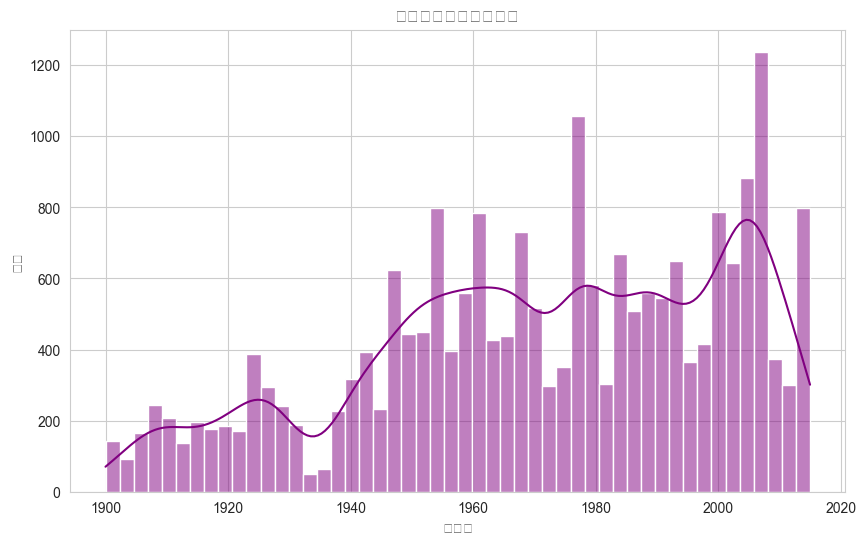

建築年の異常値除外前のデータ件数: 21607
建築年の異常値除外後のデータ件数: 16674
除外した建築年の異常値の件数: 4933


In [6]:
# 建築年の分布を確認
plt.figure(figsize=(10, 6))
sns.histplot(data['yr_built'], bins=50, kde=True, color='purple')
plt.title("建築年のヒストグラム")
plt.xlabel("建築年")
plt.ylabel("件数")
plt.show()

# 建築年の範囲を設定
lower_bound_yr_built = 1950
upper_bound_yr_built = 2024
initial_count = data.shape[0]
data = data[(data['yr_built'] >= lower_bound_yr_built) & (data['yr_built'] <= upper_bound_yr_built)]
filtered_count = data.shape[0]
removed_count = initial_count - filtered_count

print(f"建築年の異常値除外前のデータ件数: {initial_count}")
print(f"建築年の異常値除外後のデータ件数: {filtered_count}")
print(f"除外した建築年の異常値の件数: {removed_count}")


## 5.3 カスタム `whis` による箱ひげ図の表示

このセクションでは、指定した各列に対してカスタム `whis` パラメータを用いた箱ひげ図を表示し、上下限値を計算します。計算された上限値は後続のデータフィルタリングで使用します。

### スクリプト1: 箱ひげ図の表示と上下限値の計算


findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
/var/folders/73/v6765gtj31q04rybrhm_l6xh0000gn/T/ipykernel_7275/640211021.py:135: UserWarning: Glyph 20385 (\N{CJK UNIFIED IDEOGRAPH-4FA1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/73/v6765gtj31q04rybrhm_l6xh0000gn/T/ipykernel_7275/640211021.py:135: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
/var/folders/73/v6765gtj31q04rybrhm_l6xh0000gn/T/ipykernel_7275/640211021.py:135: UserWarning: Glyph 12398

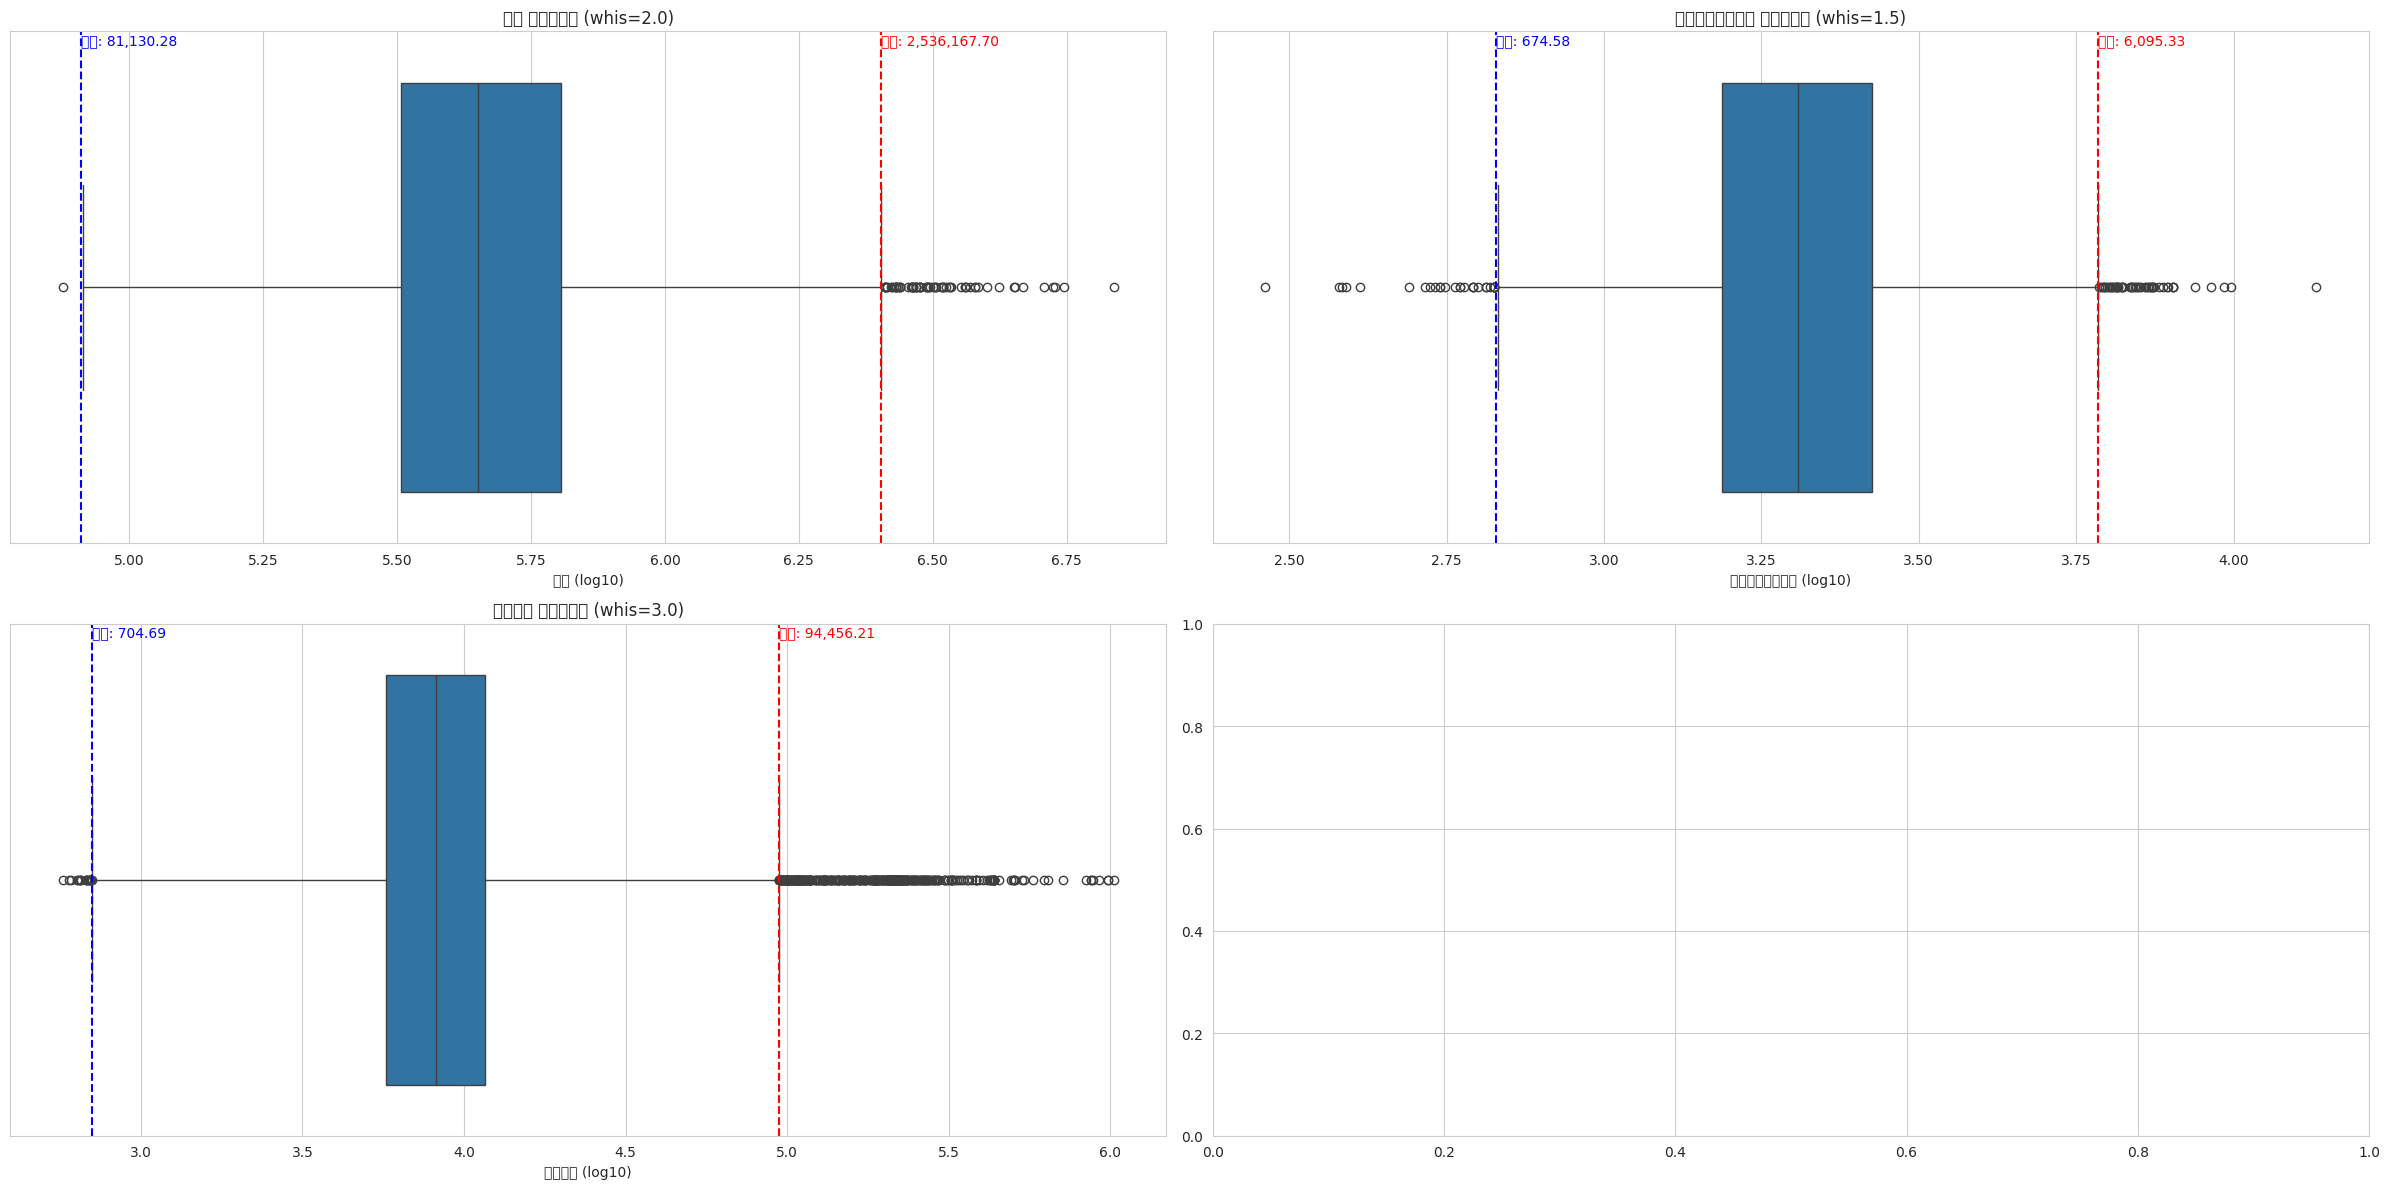

計算された上限値と下限値:
price: 上限 = 2,536,167.70, 下限 = 81,130.28
sqft_living: 上限 = 6,095.33, 下限 = 674.58
sqft_lot: 上限 = 94,456.21, 下限 = 704.69


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 日本語ラベル用の辞書を追加
feature_names_jp = {
    'date': '日付',
    'price': '価格',
    'sqft_lot': '敷地面積',
    'sqft_living': '居住スペース面積',
    'grade': '建築・デザイン品質評価',
    'lat': '緯度',
    'long': '経度',
    'yr_built': '建築年',
    'yr_renovated': 'リノベーション年',
    'year_sold': '売却年',
    'month_sold': '売却月',
    'days_since_2014_01_01': '2014年1月1日からの日数',
    'renovated_flag': 'リノベーションフラグ',
    'years_since_renovation': 'リノベーションからの経過年数',
    'age': '築年数',
}

# 日本語フォントの設定
plt.rcParams['font.family'] = 'meiryo'

# 上限値と下限値を保存する辞書を初期化
limits = {}

# Calculate 'age' as the difference between 'year_sold' and 'yr_built'
data['age'] = data['year_sold'] - data['yr_built']

def plot_boxplot_custom_whis(df, column, custom_whis=1.5, log_transform=False):
    """
    指定した列の箱ひげ図をカスタムwhisでプロットし、上限値と下限値を計算して保存する関数。
    
    Parameters:
    - df: pandas DataFrame
    - column: str, 処理対象の列名
    - custom_whis: float, IQRに乗じる係数
    - log_transform: bool, 対数変換を行うかどうか
    """
    if log_transform:
        # 対数変換
        data_transformed = np.log10(df[column])
        xlabel = f"{column} (log10)"
    else:
        data_transformed = df[column]
        xlabel = column
    
    # 箱ひげ図の作成
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=data_transformed, whis=custom_whis)
    plt.title(f"{column} の箱ひげ図 (whis={custom_whis})")
    plt.xlabel(xlabel)
    plt.show()
    
    # 四分位数とIQRの計算
    Q1 = data_transformed.quantile(0.25)
    Q3 = data_transformed.quantile(0.75)
    IQR = Q3 - Q1
    upper_whisker = Q3 + custom_whis * IQR
    lower_whisker = Q1 - custom_whis * IQR
    
    if log_transform:
        # 元のスケールに戻す
        upper_limit = 10 ** upper_whisker
        lower_limit = 10 ** lower_whisker
    else:
        upper_limit = upper_whisker
        lower_limit = lower_whisker
    
    # 上限値と下限値を辞書に保存
    limits[column] = {'upper_limit': upper_limit, 'lower_limit': lower_limit}
    
    print(f"--- {column} の上限値と下限値 ---")
    if log_transform:
        print(f"箱ひげ図の上限（対数スケール）: {upper_whisker:.2f}")
        print(f"箱ひげ図の下限（対数スケール）: {lower_whisker:.2f}")
        print(f"箱ひげ図の上限（元のスケール）: {upper_limit:,.2f} ")
        print(f"箱ひげ図の下限（元のスケール）: {lower_limit:,.2f} ")
    else:
        print(f"{column} の上限: {upper_limit:,.2f}")
        print(f"{column} の下限: {lower_limit:,.2f}")
    print("\n")

# 処理対象の列と設定（各列ごとに異なるwhisを設定）
columns_to_plot = [
    {'column': 'price', 'custom_whis': 2.0, 'log_transform': True},
    {'column': 'sqft_living', 'custom_whis': 1.5, 'log_transform': True},
    {'column': 'sqft_lot', 'custom_whis': 3.0, 'log_transform': True},
]

# 複数の箱ひげ図を一つの画像にまとめて表示（日本語ラベル対応）
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24, 12))
axes = axes.flatten()

for ax, col_info in zip(axes, columns_to_plot):
    jp_label = feature_names_jp.get(col_info['column'], col_info['column'])
    
    if col_info['log_transform']:
        data_plot = np.log10(data[col_info['column']])
        xlabel = f"{jp_label} (log10)"
    else:
        data_plot = data[col_info['column']]
        xlabel = jp_label
    
    sns.boxplot(x=data_plot, whis=col_info['custom_whis'], ax=ax)
    ax.set_title(f"{jp_label} の箱ひげ図 (whis={col_info['custom_whis']})")
    ax.set_xlabel(xlabel)
    
    # 四分位数とIQRの計算
    Q1 = data_plot.quantile(0.25)
    Q3 = data_plot.quantile(0.75)
    IQR = Q3 - Q1
    upper_whisker = Q3 + col_info['custom_whis'] * IQR
    lower_whisker = Q1 - col_info['custom_whis'] * IQR
    
    if col_info['log_transform']:
        upper_limit = 10 ** upper_whisker
        lower_limit = 10 ** lower_whisker
    else:
        upper_limit = upper_whisker
        lower_limit = lower_whisker
    
    limits[col_info['column']] = {'upper_limit': upper_limit, 'lower_limit': lower_limit}
    
    # 上限線と下限線の描画
    ax.axvline(upper_whisker, color='red', linestyle='--')
    ax.axvline(lower_whisker, color='blue', linestyle='--')
    ax.text(upper_whisker, ax.get_ylim()[1] * 0.95, f'上限: {upper_limit:,.2f}', color='red')
    ax.text(lower_whisker, ax.get_ylim()[1] * 0.95, f'下限: {lower_limit:,.2f}', color='blue')

plt.tight_layout()
plt.show()

# 上限値と下限値の確認
print("計算された上限値と下限値:")
for column, lim in limits.items():
    print(f"{column}: 上限 = {lim['upper_limit']:,.2f}, 下限 = {lim['lower_limit']:,.2f}")


## 5.4 カスタム `whis` によるデータのフィルタリング

前セクションで計算された各列の上下限値を用いて、データフレームから異常値を除外します。このセクションでは、各列ごとに異なる `whis` パラメータに基づいた上下限値を使用してデータをフィルタリングします。

### スクリプト2: データのフィルタリング


In [8]:
# フィルタリング用の関数を定義
def filter_data_custom_whis(df, limits):
    """
    指定した上限値と下限値に基づいてデータフレームをフィルタリングする関数。
    
    Parameters:
    - df: pandas DataFrame
    - limits: dict, 各列の上限値と下限値
    
    Returns:
    - フィルタリング後のDataFrame
    """
    initial_count = df.shape[0]
    for column, lim in limits.items():
        lower_limit = lim['lower_limit']
        upper_limit = lim['upper_limit']
        df = df[(df[column] >= lower_limit) & (df[column] <= upper_limit)]
        print(f"{column} の範囲 {lower_limit:,.2f} - {upper_limit:,.2f} を用いてフィルタリング完了")
    
    filtered_count = df.shape[0]
    removed_count = initial_count - filtered_count
    
    print(f"\nフィルタリング前のデータ件数: {initial_count}")
    print(f"フィルタリング後のデータ件数: {filtered_count}")
    print(f"除外したデータの件数: {removed_count}")
    
    return df

# 上限値と下限値に基づいてデータをフィルタリング
data_filtered = filter_data_custom_whis(df=data, limits=limits)

# フィルタリング後のデータ確認
display(data_filtered.head())
display(data_filtered.info())


price の範囲 81,130.28 - 2,536,167.70 を用いてフィルタリング完了
sqft_living の範囲 674.58 - 6,095.33 を用いてフィルタリング完了
sqft_lot の範囲 704.69 - 94,456.21 を用いてフィルタリング完了

フィルタリング前のデータ件数: 16674
フィルタリング後のデータ件数: 16096
除外したデータの件数: 578


date   price  sqft_lot  sqft_living  grade   lat    long  yr_built  \
0 2014-10-13  221900      5650         1180      7 47.51 -122.26      1955   
1 2014-12-09  538000      7242         2570      7 47.72 -122.32      1951   
3 2014-12-09  604000      5000         1960      7 47.52 -122.39      1965   
4 2015-02-18  510000      8080         1680      8 47.62 -122.05      1987   
6 2014-06-27  257500      6819         1715      7 47.31 -122.33      1995   

   yr_renovated  year_sold  month_sold  days_since_2014_01_01  renovated_flag  \
0             0       2014          10                    286               0   
1          1991       2014          12                    343               1   
3             0       2014          12                    343               0   
4             0       2015           2                    414               0   
6             0       2014           6                    178               0   

   years_since_renovation  age  
0                       0   59  
1                      23   63  
3                       0   49  
4                       0   28  
6                       0   19

<class 'pandas.core.frame.DataFrame'>
Index: 16096 entries, 0 to 21612
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    16096 non-null  datetime64[ns]
 1   price                   16096 non-null  int64         
 2   sqft_lot                16096 non-null  int64         
 3   sqft_living             16096 non-null  int64         
 4   grade                   16096 non-null  int64         
 5   lat                     16096 non-null  float64       
 6   long                    16096 non-null  float64       
 7   yr_built                16096 non-null  int64         
 8   yr_renovated            16096 non-null  int64         
 9   year_sold               16096 non-null  int32         
 10  month_sold              16096 non-null  int32         
 11  days_since_2014_01_01   16096 non-null  int64         
 12  renovated_flag          16096 non-null  int64      

None

## 6. 追加の特徴量エンジニアリング

データの品質向上とモデルの性能向上を図るために、追加の特徴量エンジニアリングを実施します。具体的には以下の2つのステップを行います。

1. **物件の築年数 (`age`) の算出**
2. **地域別の特徴量の作成**

これらの特徴量を追加することで、物件の物理的な特性や地理的な位置情報をモデルに反映させ、予測精度の向上を目指します。


### 6.1 物件の築年数 (`age`) の算出

`yr_built`（建築年）と `year_sold`（売却年）から物件の築年数を計算し、新たな特徴量 `age` を作成します。築年数は物件の状態や市場価値に影響を与える重要な要素となるため、モデルにおいて有用な特徴量となります。


In [9]:
# 6.1 物件の築年数 (`age`) の算出

# 物件の築年数を計算
data_filtered['age'] = data_filtered['year_sold'] - data_filtered['yr_built']

# 確認
display(data_filtered[['yr_built', 'year_sold', 'age']].head())


yr_built  year_sold  age
0      1955       2014   59
1      1951       2014   63
3      1965       2014   49
4      1987       2015   28
6      1995       2014   19

### 6.2 地域別の特徴量の作成

`lat`（緯度）と `long`（経度）を用いて、物件の地域をクラスタリングし、地域別のカテゴリ変数を作成します。ここでは、K-Meansクラスタリングを用いて物件を複数の地域グループに分類します。これにより、地理的な特徴をモデルに組み込むことが可能となります。


findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
/Users/nanaki/Development/dataScientist_exam/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32239 (\N{CJK UNIFIED IDEOGRAPH-7DEF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nanaki/Development/dataScientist_exam/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
/Users/nanaki/Development/dataScientist_exam/ven

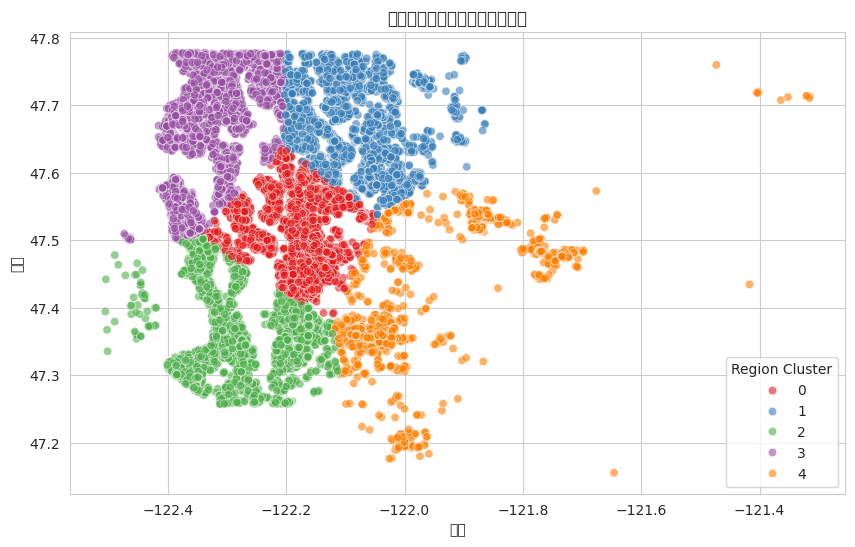

In [10]:
# 6.2 地域別の特徴量の作成

from sklearn.cluster import KMeans

# クラスタリングに使用する緯度と経度の抽出
coordinates = data_filtered[['lat', 'long']]

# クラスタ数の設定（例: 5クラス）
n_clusters = 5

# K-Meansクラスタリングの実行
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
data_filtered['region_cluster'] = kmeans.fit_predict(coordinates)

# クラスタリング結果の確認
plt.figure(figsize=(10, 6))
sns.scatterplot(x='long', y='lat', hue='region_cluster', palette='Set1', data=data_filtered, legend='full', alpha=0.6)
plt.title("物件の地域クラスタリング結果")
plt.xlabel("経度")
plt.ylabel("緯度")
plt.legend(title='Region Cluster')
plt.show()


### 6.3 特徴量のエンコーディング

クラスタリングによって作成した `region_cluster` は数値データとしてモデルに取り込むことができますが、カテゴリ変数として扱う場合はワンホットエンコーディングを適用します。以下では、`region_cluster` をダミー変数に変換します。


In [11]:
# 6.3 特徴量のエンコーディング

# ワンホットエンコーディングの適用
region_dummies = pd.get_dummies(data_filtered['region_cluster'], prefix='region')
data_final = pd.concat([data_filtered.drop('region_cluster', axis=1), region_dummies], axis=1)

# 'region_cluster' 列を data_final に保持
data_final['region_cluster'] = data_filtered['region_cluster']


平均距離: 8.36
標準偏差: 4.21
距離の閾値 (平均 + 2*標準偏差): 16.79

地理的外れ値除外前のデータ件数: 16096
地理的外れ値除外後のデータ件数: 15611
除外した地理的外れ値の件数: 485


date   price  sqft_lot  sqft_living  grade   lat    long  yr_built  \
0 2014-10-13  221900      5650         1180      7 47.51 -122.26      1955   
1 2014-12-09  538000      7242         2570      7 47.72 -122.32      1951   
4 2015-02-18  510000      8080         1680      8 47.62 -122.05      1987   
6 2014-06-27  257500      6819         1715      7 47.31 -122.33      1995   
7 2015-01-15  291850      9711         1060      7 47.41 -122.31      1963   

   yr_renovated  year_sold  ...  days_since_2014_01_01  renovated_flag  \
0             0       2014  ...                    286               0   
1          1991       2014  ...                    343               1   
4             0       2015  ...                    414               0   
6             0       2014  ...                    178               0   
7             0       2015  ...                    380               0   

   years_since_renovation  age  region_0  region_1  region_2  region_3  \
0                       0   59      True     False     False     False   
1                      23   63     False     False     False      True   
4                       0   28     False      True     False     False   
6                       0   19     False     False      True     False   
7                       0   52     False     False      True     False   

   region_4  region_cluster  
0     False               0  
1     False               3  
4     False               1  
6     False               2  
7     False               2  

[5 rows x 21 columns]

<class 'pandas.core.frame.DataFrame'>
Index: 15611 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    15611 non-null  datetime64[ns]
 1   price                   15611 non-null  int64         
 2   sqft_lot                15611 non-null  int64         
 3   sqft_living             15611 non-null  int64         
 4   grade                   15611 non-null  int64         
 5   lat                     15611 non-null  float64       
 6   long                    15611 non-null  float64       
 7   yr_built                15611 non-null  int64         
 8   yr_renovated            15611 non-null  int64         
 9   year_sold               15611 non-null  int32         
 10  month_sold              15611 non-null  int32         
 11  days_since_2014_01_01   15611 non-null  int64         
 12  renovated_flag          15611 non-null  int64      

None

findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
/Users/nanaki/Development/dataScientist_exam/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32239 (\N{CJK UNIFIED IDEOGRAPH-7DEF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nanaki/Development/dataScientist_exam/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
/Users/nanaki/Development/dataScientist_exam/venv/lib/python3.13/site-packages/IPython/cor

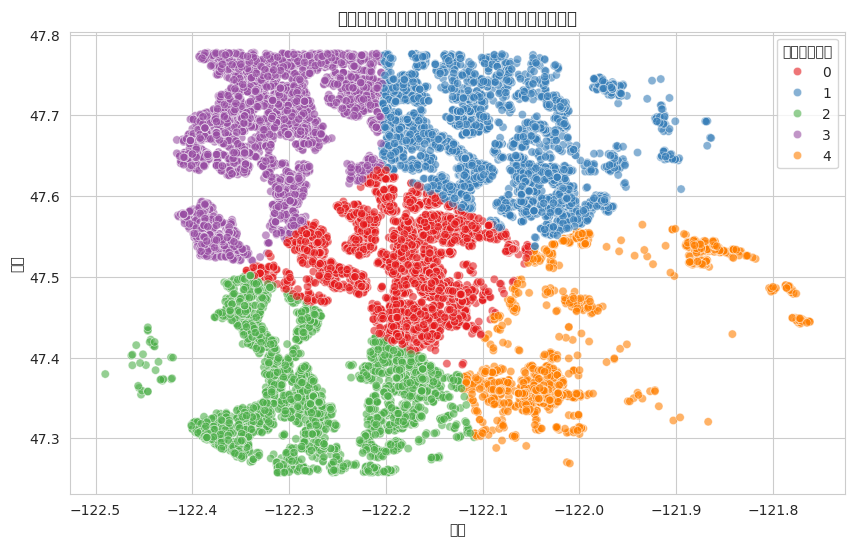

In [12]:
# 5.6 地理的外れ値の除外

import numpy as np
import pandas as pd

# クラスタの中心を取得
cluster_centers = kmeans.cluster_centers_

# 各データポイントが所属するクラスタの中心を取得
# KMeansクラスタリングで使用した 'lat' と 'long' の順序に注意
data_final['cluster_center_lat'] = cluster_centers[data_final['region_cluster'], 0]
data_final['cluster_center_long'] = cluster_centers[data_final['region_cluster'], 1]

# Haversine距離を計算する関数
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    緯度経度を用いて2点間のHaversine距離を計算する関数。
    
    Parameters:
    - lat1, lon1: 配列またはスカラー値。点1の緯度と経度。
    - lat2, lon2: 配列またはスカラー値。点2の緯度と経度。
    
    Returns:
    - distance: 点間の距離。
    """
    # ラジアンに変換
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    R = 6371  # 地球の半径
    distance = R * c
    return distance

# 各データポイントからクラスタ中心までの距離を計算
data_final['distance_to_centroid'] = haversine_distance(
    data_final['lat'],
    data_final['long'],
    data_final['cluster_center_lat'],
    data_final['cluster_center_long']
)

# 距離の統計量を確認
distance_mean = data_final['distance_to_centroid'].mean()
distance_std = data_final['distance_to_centroid'].std()
distance_threshold = distance_mean + 2 * distance_std

print(f"平均距離: {distance_mean:.2f}")
print(f"標準偏差: {distance_std:.2f}")
print(f"距離の閾値 (平均 + 2*標準偏差): {distance_threshold:.2f}")

# 外れ値を除外
initial_count = data_final.shape[0]
data_final = data_final[data_final['distance_to_centroid'] <= distance_threshold]
filtered_count = data_final.shape[0]
removed_count = initial_count - filtered_count

print(f"\n地理的外れ値除外前のデータ件数: {initial_count}")
print(f"地理的外れ値除外後のデータ件数: {filtered_count}")
print(f"除外した地理的外れ値の件数: {removed_count}")

# 不要な列を削除
data_final = data_final.drop(['cluster_center_lat', 'cluster_center_long', 'distance_to_centroid'], axis=1)

# フィルタリング後のデータ確認
display(data_final.head())
display(data_final.info())

# 地理的外れ値除外後のデータをプロット

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='long',
    y='lat',
    hue='region_cluster',
    palette='Set1',
    data=data_final,
    legend='full',
    alpha=0.6
)
plt.title("地理的外れ値除外後の物件の地域クラスタリング結果")
plt.xlabel("経度")
plt.ylabel("緯度")
plt.legend(title='地域クラスタ')
plt.show()

### 6.4 リノベーション無し物件はリノベーション済物件と取り扱いを変える
リノベーション無しの物件のデータはリノベーション経過年数が0になっており、リノベーション経過年数が1年のデータとデータとして近くなってしまうが、実際にはそこに大きな違いがある。そのため、リノベーション無しの物件はリノベーション経過年数を0にせず、NaNにする。

In [13]:
# ### リノベーションフラグが0のデータの処理

# リノベーションフラグが0のデータについて、リノベーション経過年数 (`years_since_renovation`) を0にするのではなく、`NaN`（欠損値）に設定します。

import numpy as np

# リノベーションフラグが0の行の 'years_since_renovation' を NaN に設定
data_final.loc[data_final['renovated_flag'] == 0, 'years_since_renovation'] = np.nan

# フィルタリング後のデータを確認
display(data_final.head())
display(data_final.info())


date   price  sqft_lot  sqft_living  grade   lat    long  yr_built  \
0 2014-10-13  221900      5650         1180      7 47.51 -122.26      1955   
1 2014-12-09  538000      7242         2570      7 47.72 -122.32      1951   
4 2015-02-18  510000      8080         1680      8 47.62 -122.05      1987   
6 2014-06-27  257500      6819         1715      7 47.31 -122.33      1995   
7 2015-01-15  291850      9711         1060      7 47.41 -122.31      1963   

   yr_renovated  year_sold  ...  days_since_2014_01_01  renovated_flag  \
0             0       2014  ...                    286               0   
1          1991       2014  ...                    343               1   
4             0       2015  ...                    414               0   
6             0       2014  ...                    178               0   
7             0       2015  ...                    380               0   

   years_since_renovation  age  region_0  region_1  region_2  region_3  \
0                     NaN   59      True     False     False     False   
1                   23.00   63     False     False     False      True   
4                     NaN   28     False      True     False     False   
6                     NaN   19     False     False      True     False   
7                     NaN   52     False     False      True     False   

   region_4  region_cluster  
0     False               0  
1     False               3  
4     False               1  
6     False               2  
7     False               2  

[5 rows x 21 columns]

<class 'pandas.core.frame.DataFrame'>
Index: 15611 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    15611 non-null  datetime64[ns]
 1   price                   15611 non-null  int64         
 2   sqft_lot                15611 non-null  int64         
 3   sqft_living             15611 non-null  int64         
 4   grade                   15611 non-null  int64         
 5   lat                     15611 non-null  float64       
 6   long                    15611 non-null  float64       
 7   yr_built                15611 non-null  int64         
 8   yr_renovated            15611 non-null  int64         
 9   year_sold               15611 non-null  int32         
 10  month_sold              15611 non-null  int32         
 11  days_since_2014_01_01   15611 non-null  int64         
 12  renovated_flag          15611 non-null  int64      

None

## 7. 詳細な探索的データ分析 (EDA)

追加の特徴量エンジニアリングを完了した後、データの詳細な探索的データ分析 (EDA) を実施します。このステップでは、データの傾向やパターン、特徴量間の関係性を深く理解し、予測モデルの構築に向けたインサイトを得ることを目的とします。

以下のサブセクションに分けて分析を行います。

1. **ターゲット変数 (`価格`) の分布確認**
2. **主要特徴量とターゲット変数の関係分析**
3. **相関行列の作成と可視化**
4. **カテゴリ変数の分析**
5. **地域クラスタリングの詳細分析**
6. **特徴量間の関係性の可視化**

---


### 7.1 ターゲット変数 (`価格`) の分布確認

予測対象となる `価格` の分布を確認し、データの偏りや異常値の存在を把握します。価格の分布が偏っている場合、対数変換などの前処理を検討します。


findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
/Users/nanaki/Development/dataScientist_exam/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20214 (\N{CJK UNIFIED IDEOGRAPH-4EF6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nanaki/Development/dataScientist_exam/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
/Users

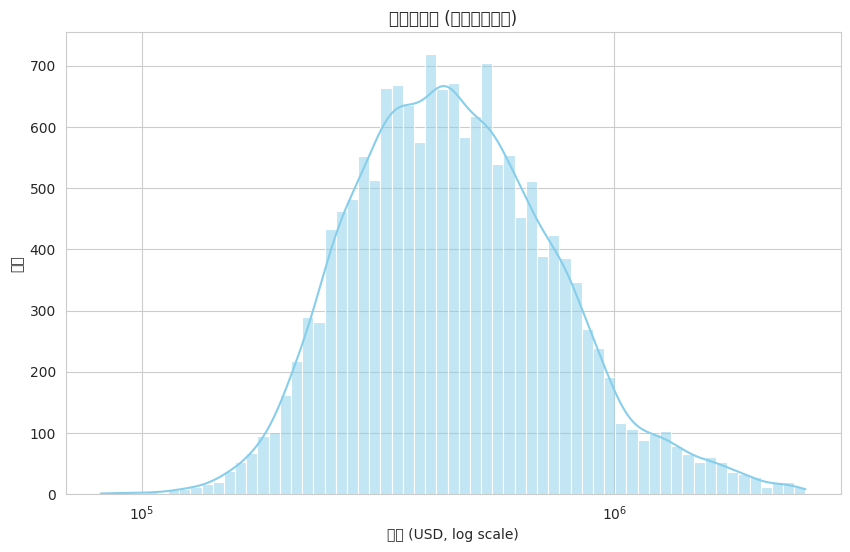

件数         15,611.00
平均        525,366.40
標準偏差      307,532.65
最小         82,000.00
25%       320,000.00
中央値       445,000.00
75%       635,000.00
最大      2,535,000.00
Name: price, dtype: object

In [14]:
# 7.1 ターゲット変数 (`価格`) の分布確認

import matplotlib.pyplot as plt
import seaborn as sns

# 価格のヒストグラム（対数スケール）
plt.figure(figsize=(10, 6))
sns.histplot(data_final['price'], kde=True, color='skyblue', log_scale=True)
plt.title("価格の分布 (対数スケール)")
plt.xlabel("価格 (USD, log scale)")
plt.ylabel("件数")
plt.show()

# 価格の基本統計量
price_stats = data_final['price'].describe()
price_stats = price_stats.rename({
    'count': '件数',
    'mean': '平均',
    'std': '標準偏差',
    'min': '最小',
    '25%': '25%',
    '50%': '中央値',
    '75%': '75%',
    'max': '最大'
})
price_stats = price_stats.apply(lambda x: f"{x:,.2f}")
display(price_stats)


対数グラフにおいてきれいな正規分布に近い形状になっており、このままで問題はなさそう。

### 7.2 主要特徴量とターゲット変数の関係分析

主要な数値特徴量とターゲット変数 `価格` との関係を可視化し、相関の強さやパターンを確認します。これにより、価格に影響を与える可能性のある重要な特徴量を特定します。


findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
/var/folders/73/v6765gtj31q04rybrhm_l6xh0000gn/T/ipykernel_7275/2251161340.py:31: UserWarning: Glyph 25975 (\N{CJK UNIFIED IDEOGRAPH-6577}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/73/v6765gtj31q04rybrhm_l6xh0000gn/T/ipykernel_7275/2251161340.py:31: UserWarning: Glyph 22320 (\N{CJK UNIFIED IDEOGRAPH-5730}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/73/v6765gtj31q04rybrhm_l6xh0000gn/T/ipykernel_7275/2251161340.py:31: UserWarning: Glyph 38754 (\N{CJK UNIFIED IDEOGRAPH-9762}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/73/v6765gtj31q04rybrhm_l6xh0000gn/T/ipykernel_7275/2251161340.py:3

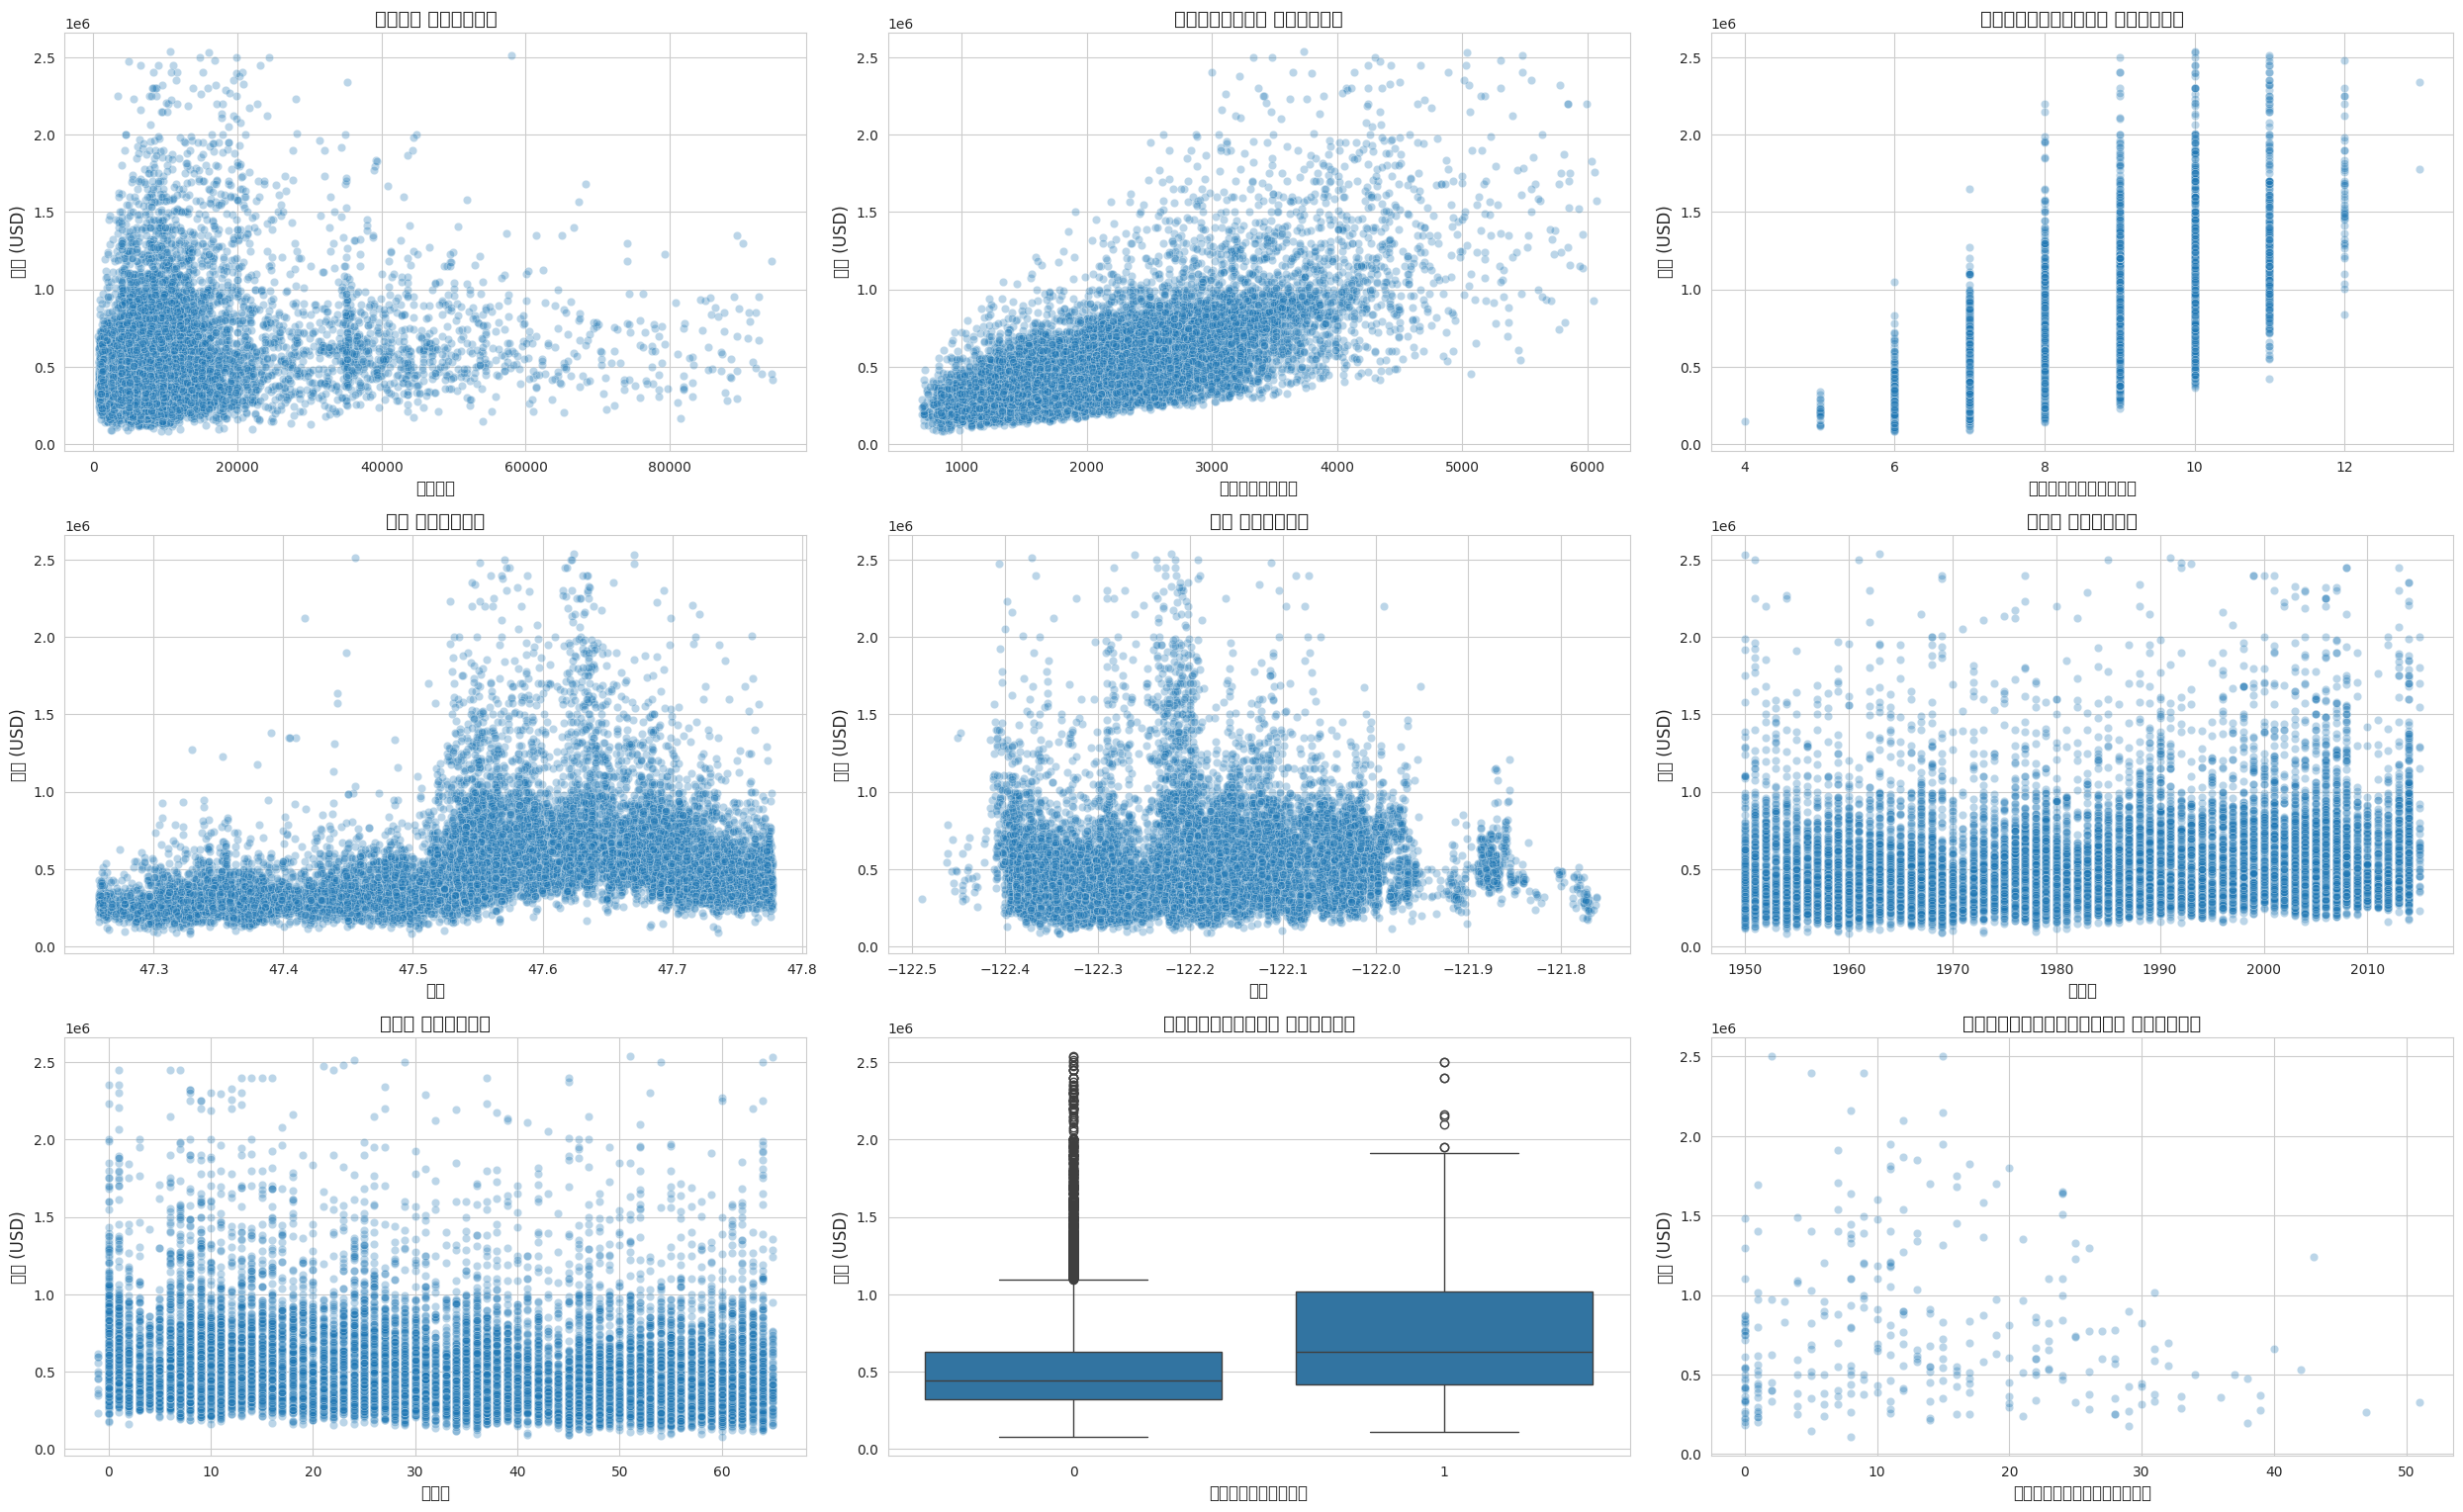

主要特徴量と価格の相関係数 (日本語表示):


価格との相関係数
建築・デザイン品質評価         0.71
居住スペース面積            0.70
緯度                  0.37
敷地面積                0.18
建築年                 0.16
リノベーションフラグ          0.12
経度                  0.09
リノベーションからの経過年数     -0.06
築年数                -0.16

In [15]:
# 7.2 主要特徴量とターゲット変数の関係分析

# 主要数値特徴量のリストにリノベーション関連の特徴量を追加
numeric_features = ['sqft_lot', 'sqft_living', 'grade', 'lat', 'long', 'yr_built', 'age', 'renovated_flag', 'years_since_renovation']

# 日本語ラベルの辞書にリノベーション関連の特徴量を追加
feature_jp = {
    'sqft_lot': '敷地面積',
    'sqft_living': '居住スペース面積',
    'grade': '建築・デザイン品質評価',
    'lat': '緯度',
    'long': '経度',
    'yr_built': '建築年',
    'age': '築年数',
    'renovated_flag': 'リノベーションフラグ',
    'years_since_renovation': 'リノベーションからの経過年数'
}

# 散布図を作成し、各特徴量を日本語で表示
plt.figure(figsize=(25, 20))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(4, 3, i)
    if feature == 'renovated_flag':
        sns.boxplot(x=data_final[feature], y=data_final['price'])
    else:
        sns.scatterplot(x=data_final[feature], y=data_final['price'], alpha=0.3)
    jp_label = feature_jp.get(feature, feature)
    plt.title(f"{jp_label} と価格の関係", fontsize=14)
    plt.xlabel(jp_label, fontsize=12)
    plt.ylabel("価格 (USD)", fontsize=12)
plt.tight_layout()
plt.show()

# 各特徴量と価格の相関係数
correlations = {}
for feature in numeric_features:
    corr = data_final['price'].corr(data_final[feature])
    correlations[feature] = corr

# 相関係数をテーブル形式で表示 (日本語化)
feature_names = {
    'sqft_lot': '敷地面積',
    'sqft_living': '居住スペース面積',
    'grade': '建築・デザイン品質評価',
    'lat': '緯度',
    'long': '経度',
    'yr_built': '建築年',
    'age': '築年数',
    'renovated_flag': 'リノベーションフラグ',
    'years_since_renovation': 'リノベーションからの経過年数'
}

corr_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['価格との相関係数'])
corr_df.index = corr_df.index.to_series().apply(lambda x: feature_names.get(x, x))
corr_df = corr_df.sort_values(by='価格との相関係数', ascending=False).round(2)

print("主要特徴量と価格の相関係数 (日本語表示):")
display(corr_df)


他のデータと極端に離れた外れ値データは少なくなっており、フィルタリングが正しく機能したことがわかる。

### 7.3 相関行列の作成と可視化

数値特徴量間の相関関係を把握するために、相関行列を作成しヒートマップで可視化します。これにより、相関の強いペアや多重共線性の可能性を確認します。


findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
/Users/nanaki/Development/dataScientist_exam/venv/lib/python3.13/site-packages/seaborn/utils.py:61: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/nanaki/Development/dataScientist_exam/venv/lib/python3.13/site-packages/seaborn/utils.py:61: UserWarning: Glyph 20184 (\N{CJK UNIFIED IDEOGRAPH-4ED8}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
findfont: Font family 'meiryo' not found.
/Users/nanaki/Development/dataScientist_exam/venv/lib/python3.13/site-packages/seaborn/utils.py:61: UserWarning: Glyph 20385 (\N{CJK UNIFIED IDEOGRAPH-4FA1}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/nanaki/Development/dataScientist_exam/venv/lib/python3.13/site-packages/seaborn/utils.py:61: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
findfont: Font family 'mei

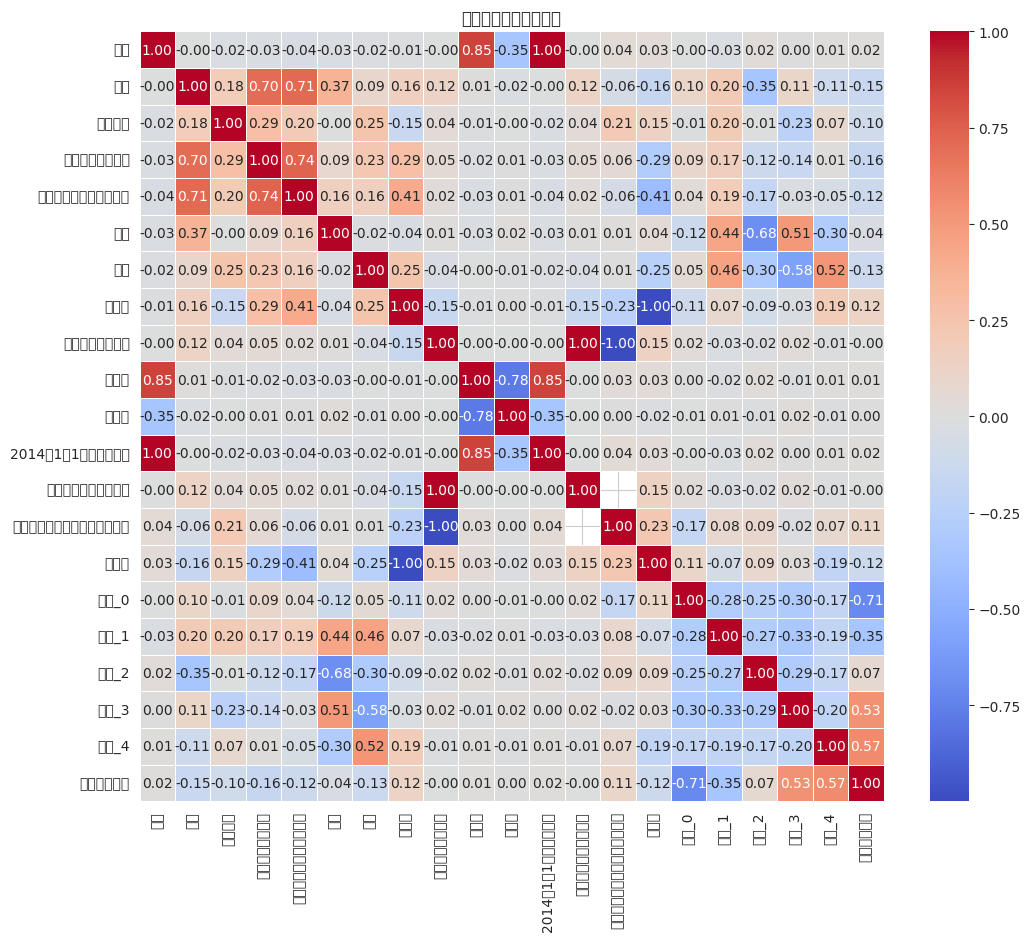

In [16]:
# 列名の日本語対応辞書を更新
feature_names_jp = {
    'date': '日付',
    'price': '価格',
    'sqft_lot': '敷地面積',
    'sqft_living': '居住スペース面積',
    'grade': '建築・デザイン品質評価',
    'lat': '緯度',
    'long': '経度',
    'yr_built': '建築年',
    'yr_renovated': 'リノベーション年',
    'year_sold': '売却年',
    'month_sold': '売却月',
    'days_since_2014_01_01': '2014年1月1日からの日数',
    'renovated_flag': 'リノベーションフラグ',
    'years_since_renovation': 'リノベーションからの経過年数',
    'age': '築年数',
    'region_0': '地域_0',
    'region_1': '地域_1',
    'region_2': '地域_2',
    'region_3': '地域_3',
    'region_4': '地域_4',
    'region_cluster': '地域クラスタ'
}

# 相関行列の計算
corr_matrix = data_final.corr()

# 日本語フォントの設定
plt.rcParams['font.family'] = 'meiryo'

# 列名を日本語に変更
corr_matrix = corr_matrix.rename(columns=feature_names_jp).rename(index=feature_names_jp)

# ヒートマップの作成
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("数値特徴量の相関行列")
plt.show()
# 相関行列を表形式で表示（スタイル付き）
display(
    corr_matrix.style
    .background_gradient(cmap='coolwarm', vmin=-1, vmax=1)
    .format("{:.2f}")
)

### 7.4 カテゴリ変数の分析

カテゴリ変数である `region_cluster` に基づいて、価格やその他の数値特徴量の分布を比較します。これにより、異なる地域クラスタ間での価格の違いや特徴の違いを確認します。


/var/folders/73/v6765gtj31q04rybrhm_l6xh0000gn/T/ipykernel_7275/1561730076.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_melted['cluster'] = filtered_melted['region'].str.replace('region_', '').astype(int)
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
/Users/nanaki/Development/dataScientist_exam/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20385 (\N{CJK UNIFIED IDEO

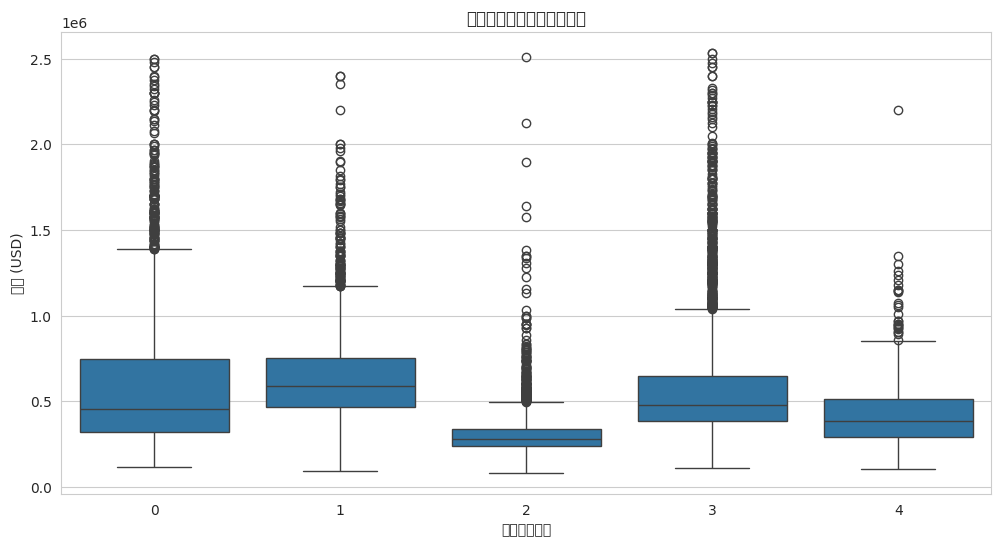

地域クラスタごとの平均価格:


cluster      price
0        0 587,188.63
1        1 635,006.68
2        2 309,033.18
3        3 580,973.40
4        4 422,635.92

In [17]:
# 7.4 カテゴリ変数の分析

# region_cluster のダミー変数名を取得
region_columns = [col for col in data_final.columns if col.startswith('region_') and col != 'region_cluster']

# データを長い形式に変換
melted = pd.melt(data_final, id_vars='price', value_vars=region_columns, var_name='region', value_name='is_region')

# region が True の行のみ抽出
filtered_melted = melted[melted['is_region']]

# クラスタ番号を抽出
filtered_melted['cluster'] = filtered_melted['region'].str.replace('region_', '').astype(int)

# 各地域クラスタごとの価格の分布をボックスプロットで確認
plt.figure(figsize=(12, 6))
sns.boxplot(x='cluster', y='price', data=filtered_melted)
plt.title("各地域クラスタの価格分布")
plt.xlabel("地域クラスタ")
plt.ylabel("価格 (USD)")
plt.show()

# 地域クラスタごとの平均価格を計算
region_price_mean = filtered_melted.groupby('cluster')['price'].mean().reset_index()
print("地域クラスタごとの平均価格:")
display(region_price_mean)


### 7.5 地域クラスタリングの詳細分析

地域クラスタリングに基づき、各クラスタの特徴を詳細に分析します。具体的には、各クラスタの平均価格、敷地面積、居住スペース面積などを比較し、地域ごとの特性を把握します。


/var/folders/73/v6765gtj31q04rybrhm_l6xh0000gn/T/ipykernel_7275/3947716678.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='region_cluster', y='price', data=data_final, palette='Set2')
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
/Users/nanaki/Development/dataScientist_exam/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20385 (\N{CJK UNIFIED IDEOGRAPH-4FA1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io

地域クラスタの分布:
region_cluster
3    4032
1    3682
0    3222
2    3053
4    1622
Name: count, dtype: int64

データ型の確認:
region_cluster    int32
price             int64
sqft_lot          int64
sqft_living       int64
age               int64
dtype: object

データ型の再確認:
region_cluster    int32
price             int64
sqft_lot          int64
sqft_living       int64
age               int64
grade             int64
dtype: object


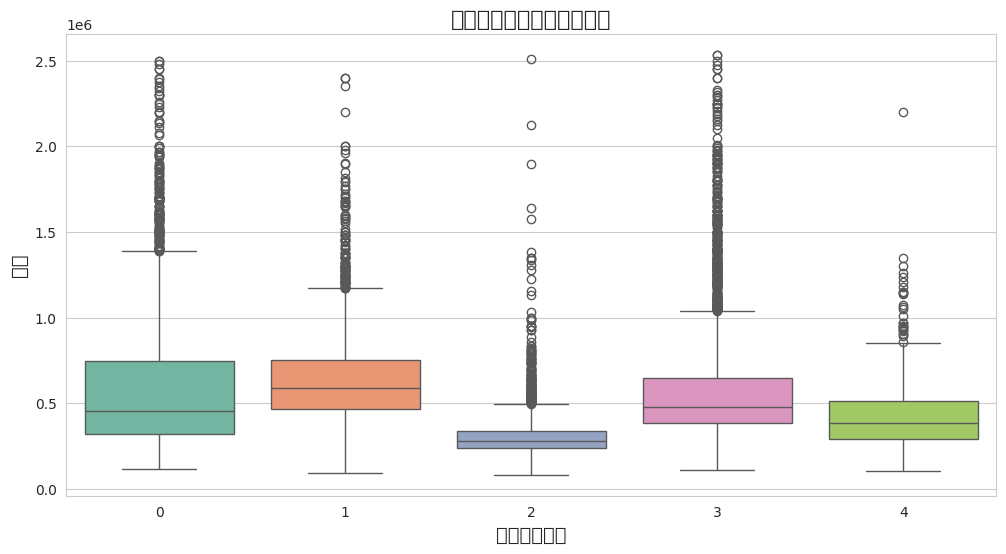


地域クラスタ別の価格統計量:


count       mean        std        min        25%  \
region_cluster                                                        
クラスタ 0         3,222.00 587,188.63 383,808.95 115,000.00 320,000.00   
クラスタ 1         3,682.00 635,006.68 241,794.59  90,000.00 468,000.00   
クラスタ 2         3,053.00 309,033.18 141,700.37  82,000.00 235,245.00   
クラスタ 3         4,032.00 580,973.40 331,489.28 107,000.00 384,000.00   
クラスタ 4         1,622.00 422,635.92 181,458.82 105,000.00 290,000.00   

                      50%        75%          max  
region_cluster                                     
クラスタ 0         453,000.00 747,125.00 2,500,000.00  
クラスタ 1         588,750.00 750,000.00 2,400,000.00  
クラスタ 2         279,500.00 340,000.00 2,510,000.00  
クラスタ 3         480,000.00 646,000.00 2,535,000.00  
クラスタ 4         382,750.00 515,000.00 2,200,000.00

/var/folders/73/v6765gtj31q04rybrhm_l6xh0000gn/T/ipykernel_7275/3947716678.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='region_cluster', y=feature, data=data_final, palette='Set3')
/var/folders/73/v6765gtj31q04rybrhm_l6xh0000gn/T/ipykernel_7275/3947716678.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='region_cluster', y=feature, data=data_final, palette='Set3')
/var/folders/73/v6765gtj31q04rybrhm_l6xh0000gn/T/ipykernel_7275/3947716678.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='region_cluster', y=feature, data

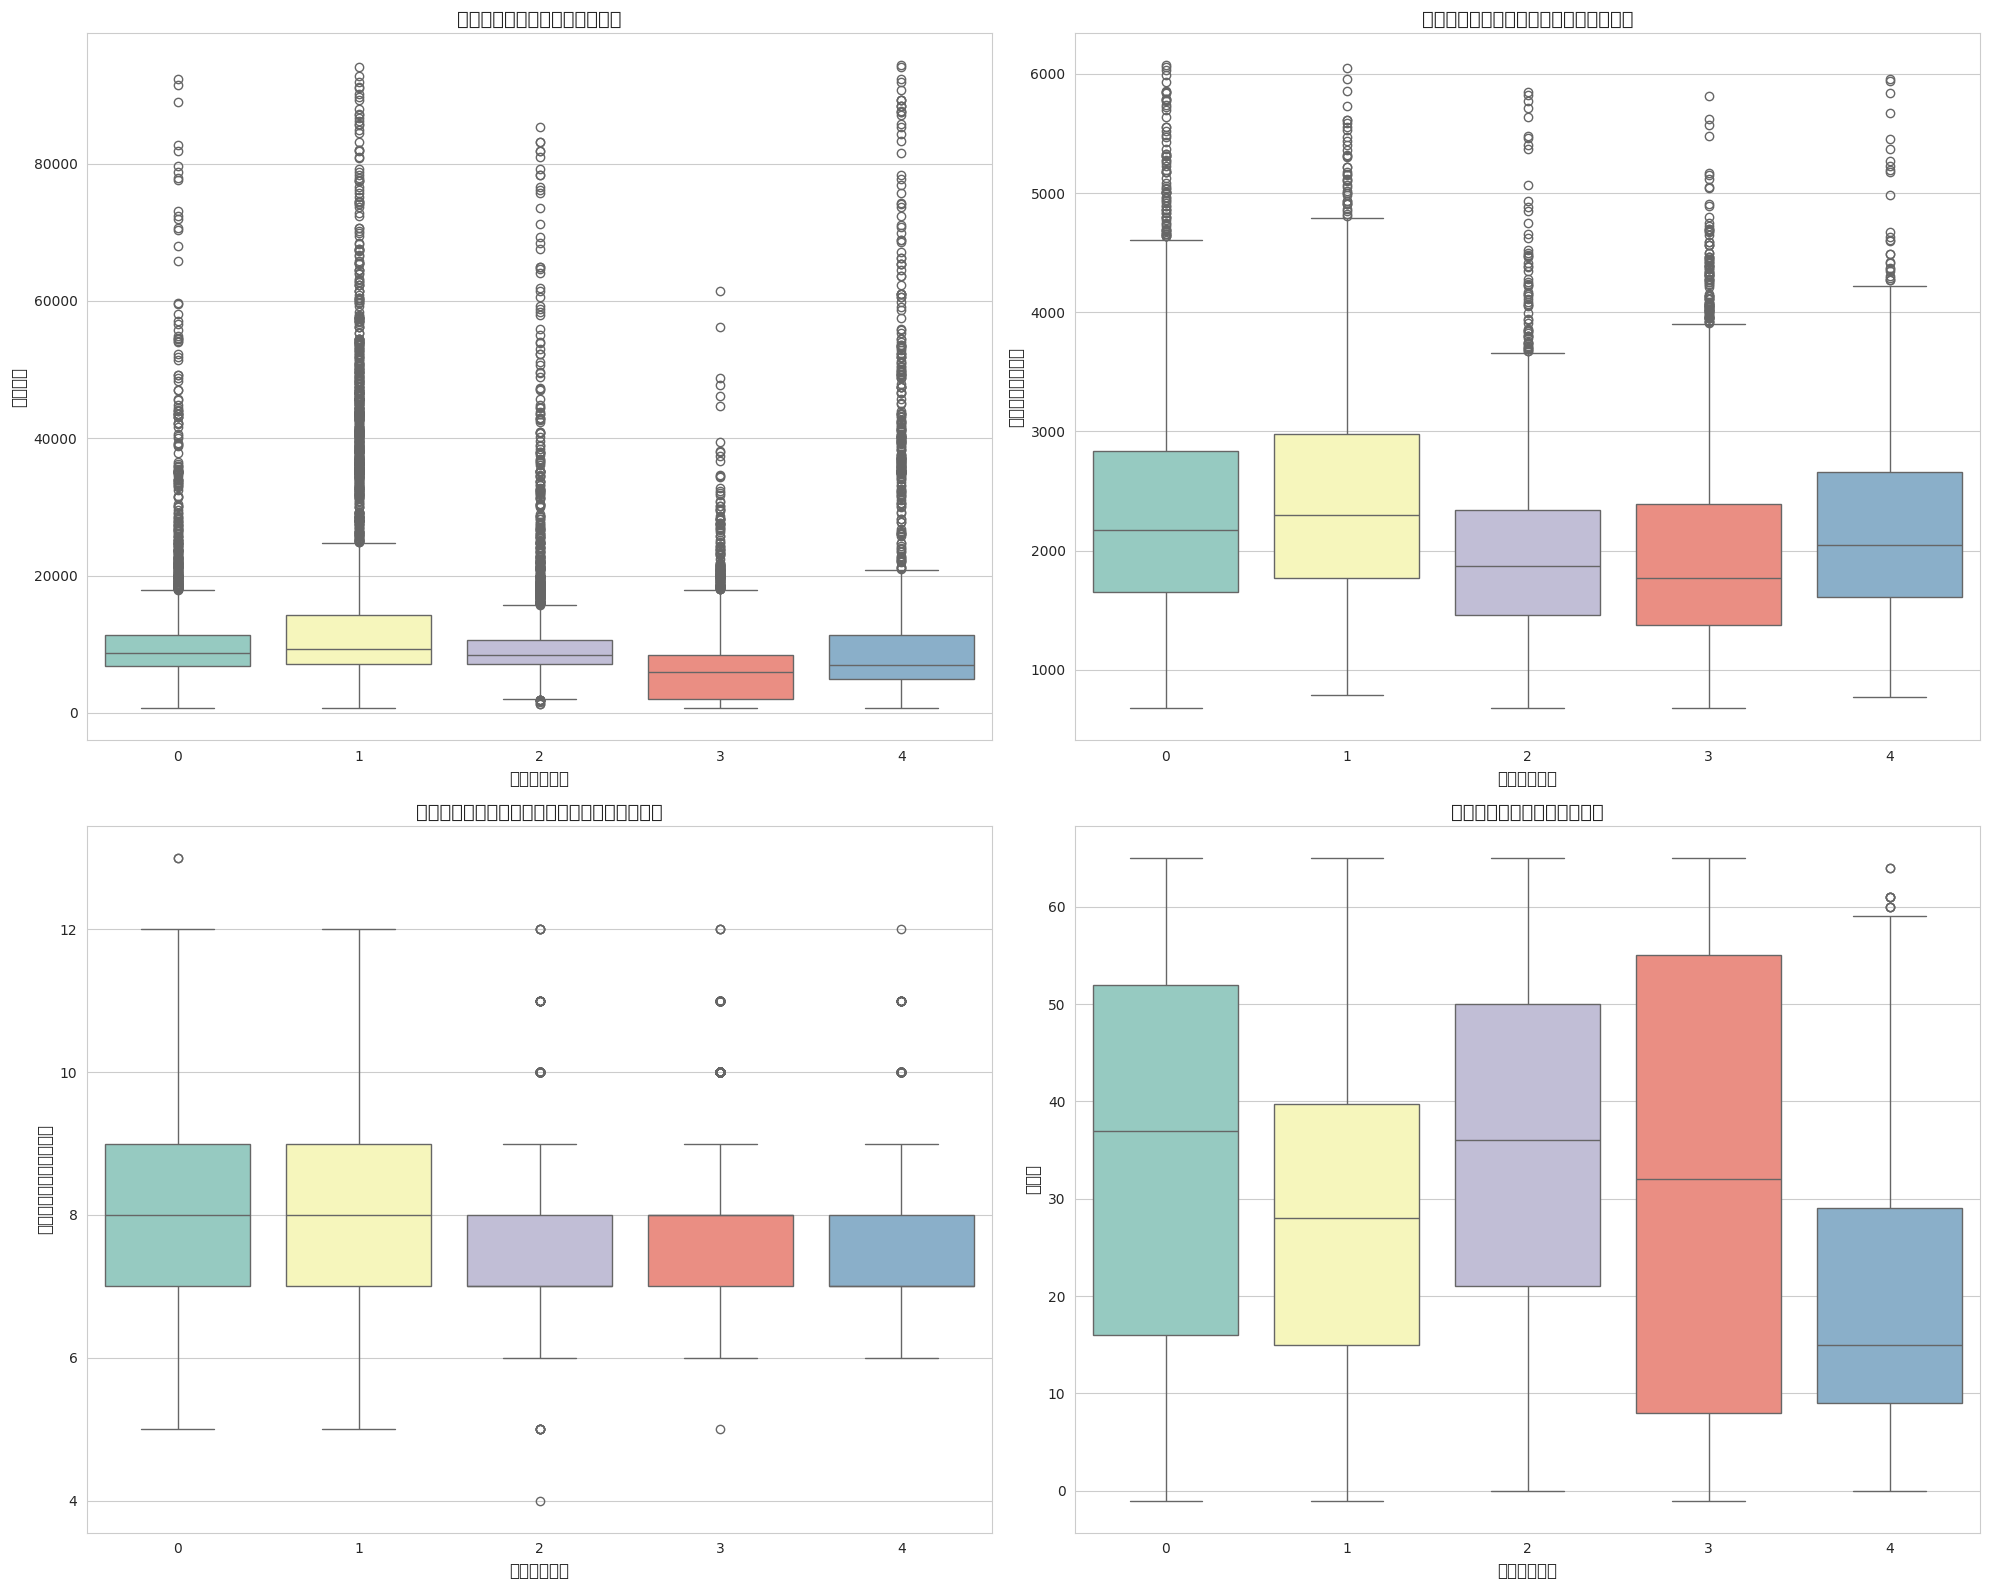


地域クラスタ別の主要特徴量の平均値:


平均価格    平均敷地面積  平均居住スペース面積  平均築年数
region_cluster                                        
クラスタ 0         587,188.63 10,534.23    2,326.42  34.91
クラスタ 1         635,006.68 14,782.50    2,424.54  28.44
クラスタ 2         309,033.18 10,638.35    1,963.82  34.28
クラスタ 3         580,973.40  6,453.71    1,964.34  31.82
クラスタ 4         422,635.92 13,156.20    2,193.07  20.02


地域クラスタ別の価格との相関係数:


region_cluster  敷地面積との相関係数  居住スペース面積との相関係数  建築・デザイン品質評価との相関係数  築年数との相関係数
0              0        0.23            0.75               0.76      -0.21
1              1        0.23            0.78               0.75      -0.35
2              2        0.34            0.69               0.63      -0.21
3              3        0.27            0.73               0.71      -0.06
4              4        0.18            0.79               0.78      -0.33

findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
/Users/nanaki/Development/dataScie

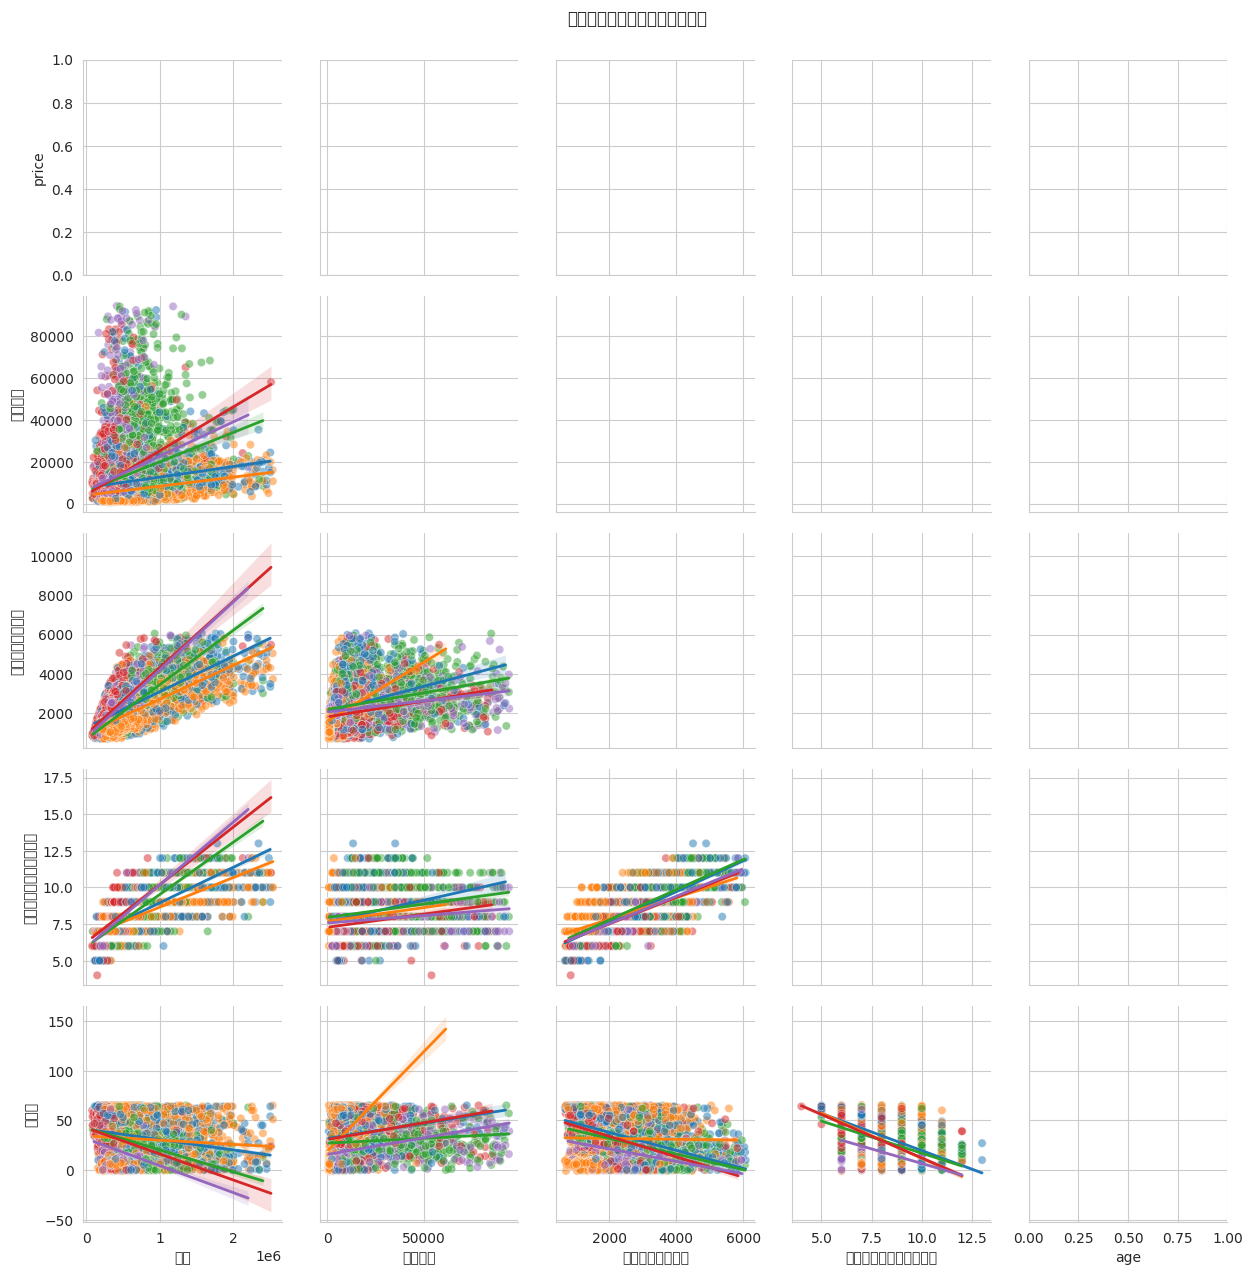

findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
/var/folders/73/v6765gtj31q04rybrhm_l6xh0000gn/T/ipykernel_7275/3947716678.py:206: UserWarning: Glyph 20385 (\N{CJK UNIFIED IDEOGRAPH-4FA1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/73/v6765gtj31q04rybrhm_l6xh0000gn/T/ipykernel_7275/3947716678.py:206: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font famil

<Figure size 3000x500 with 0 Axes>

findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not

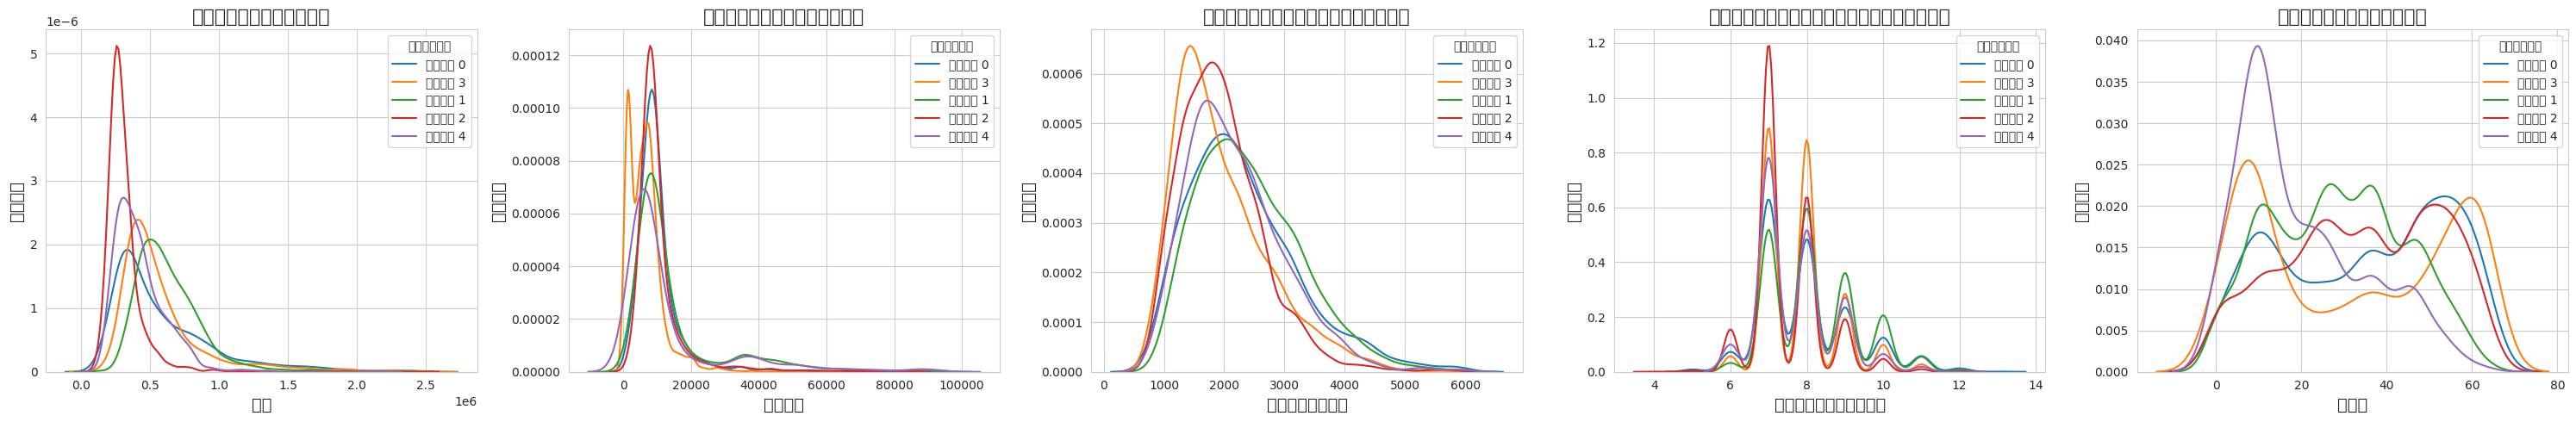

In [18]:
# ==========================
# 7.5 地域クラスタリングの詳細分析
# ==========================
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------
# 1. データの確認・データ型の変換など
# ----------------------------------
print("地域クラスタの分布:")
print(data_final['region_cluster'].value_counts())

print("\nデータ型の確認:")
print(data_final[['region_cluster', 'price', 'sqft_lot', 'sqft_living', 'age']].dtypes)

# region_cluster が数値型でない場合は変換
if not pd.api.types.is_numeric_dtype(data_final['region_cluster']):
    data_final['region_cluster'] = pd.to_numeric(data_final['region_cluster'], errors='coerce')

# 後続の分析で使用するカラム群
numeric_columns = ['price', 'sqft_lot', 'sqft_living', 'age']

# 集計対象の数値カラムをすべて数値型に変換
for col in numeric_columns:
    data_final[col] = pd.to_numeric(data_final[col], errors='coerce')

# 'grade' カラムがある場合も数値型に変換する
if 'grade' in data_final.columns and not pd.api.types.is_numeric_dtype(data_final['grade']):
    data_final['grade'] = pd.to_numeric(data_final['grade'], errors='coerce')

print("\nデータ型の再確認:")
print(data_final[['region_cluster'] + numeric_columns + ['grade']].dtypes)

# ----------------------------------
# 2. 価格の分布比較（クラスタごと）
# ----------------------------------
if 'price' in data_final.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='region_cluster', y='price', data=data_final, palette='Set2')
    plt.title("地域クラスタ別の価格分布", fontsize=16)
    plt.xlabel("地域クラスタ", fontsize=14)
    plt.ylabel("価格", fontsize=14)
    plt.show()
else:
    print("Error: 'price' column is missing from data_final. Please ensure it is included in the DataFrame.")

# クラスタごとの価格の基本統計量
price_stats = data_final.groupby('region_cluster')['price'].describe().round(2)
price_stats = price_stats.rename(index=lambda x: f"クラスタ {int(x)}")
print("\n地域クラスタ別の価格統計量:")
display(price_stats)

# ----------------------------------
# 3. その他の主要な数値特徴量の分布比較（boxplot）
# ----------------------------------
numeric_features_jp = {
    'sqft_lot': '敷地面積',
    'sqft_living': '居住スペース面積',
    'grade': '建築・デザイン品質評価',
    'age': '築年数'
}

plt.figure(figsize=(20, 16))
for i, (feature, feature_japanese) in enumerate(numeric_features_jp.items(), 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='region_cluster', y=feature, data=data_final, palette='Set3')
    plt.title(f"地域クラスタ別の{feature_japanese}分布", fontsize=14)
    plt.xlabel("地域クラスタ", fontsize=12)
    plt.ylabel(feature_japanese, fontsize=12)
plt.tight_layout()
plt.show()

# 各クラスタごとの平均値
mean_values = data_final.groupby('region_cluster')[['price','sqft_lot','sqft_living','age']].mean().round(2)
mean_values = mean_values.rename(columns={
    'price': '平均価格',
    'sqft_lot': '平均敷地面積',
    'sqft_living': '平均居住スペース面積',
    'age': '平均築年数'
})
mean_values = mean_values.rename(index=lambda x: f"クラスタ {int(x)}")
print("\n地域クラスタ別の主要特徴量の平均値:")
display(mean_values)

# ----------------------------------
# 4. 地域クラスタ別の相関係数 (参考: リノベーションフラグの処理)
# ----------------------------------
# 相関計算対象に 'grade' を含める場合は、明示的に列を指定
cols_for_corr = ['price', 'sqft_lot', 'sqft_living', 'grade', 'age']

# クラスタ番号が欠損している行を除外しておく (KeyError 防止対策)
data_final = data_final.dropna(subset=['region_cluster'])

# 相関行列を計算
corr_result = data_final.groupby('region_cluster')[cols_for_corr].corr()

# 'price' の行を除外し、列として展開
# （階層インデックスの level=1 を展開し、'price' 列だけ取得）
corr_cluster = corr_result[corr_result.index.get_level_values(1) != 'price'].unstack(level=1)['price'].round(2)

# reset_indexしてカラムを展開
corr_cluster = corr_cluster.reset_index()

# カラム名をわかりやすく変更
# [region_cluster, sqft_lot, sqft_living, grade, age] の順になる
corr_cluster.columns = [
    'region_cluster', 
    '敷地面積との相関係数', 
    '居住スペース面積との相関係数', 
    '建築・デザイン品質評価との相関係数', 
    '築年数との相関係数'
]

# 地域クラスタを「クラスタX」にマッピング
corr_cluster['region_cluster'] = corr_cluster['region_cluster'].astype(int).astype(str).replace(
    {k: f"クラスタ {int(k)}" for k in data_final['region_cluster'].unique()}
)

print("\n地域クラスタ別の価格との相関係数:")
display(corr_cluster)

# ----------------------------------
# 5. ペアプロット (地域クラスタを hue として重ね描き)
# ----------------------------------
data_final['region_cluster_cat'] = data_final['region_cluster'].astype(str)

# 色の選定（クラスタ数に応じて自動調整）
num_clusters = data_final['region_cluster_cat'].nunique()
palette = sns.color_palette("tab10", n_colors=num_clusters)

# 英語の特徴量名を日本語にマッピング
feature_names_jp = {
    'price': '価格',
    'sqft_lot': '敷地面積',
    'sqft_living': '居住スペース面積',
    'grade': '建築・デザイン品質評価',
    'age': '築年数'
}

g = sns.PairGrid(
    data_final, 
    vars=['price', 'sqft_lot', 'sqft_living', 'grade', 'age'], 
    hue='region_cluster_cat', 
    palette=palette,
    height=2.5
)
g.map_lower(sns.scatterplot, alpha=0.5)

# 下三角部分に回帰線を追加
for i in range(len(g.axes)):
    for j in range(len(g.axes)):
        if j < i:  # 下三角部分のみ
            ax = g.axes[i, j]
            if ax is not None:
                x_col = g.x_vars[j]
                y_col = g.y_vars[i]
                for cluster_label, color in zip(data_final['region_cluster_cat'].unique(), palette):
                    subset = data_final[data_final['region_cluster_cat'] == cluster_label]
                    sns.regplot(
                        x=x_col, 
                        y=y_col,
                        data=subset, 
                        scatter=False, 
                        ax=ax, 
                        color=color, 
                        line_kws={'linewidth':2}
                    )
                # 軸ラベルを日本語に設定
                ax.set_xlabel(feature_names_jp.get(x_col, x_col), fontsize=10)
                ax.set_ylabel(feature_names_jp.get(y_col, y_col), fontsize=10)

plt.suptitle("地域クラスタ別のペアプロット", y=1.02)
plt.show()

# ----------------------------------
# 6. 各数値特徴量の相対度数線グラフ (地域クラスタごとの重ね描き)
# ----------------------------------
features_to_plot = ['price', 'sqft_lot', 'sqft_living', 'grade', 'age']
features_jp = {
    'price': '価格',
    'sqft_lot': '敷地面積',
    'sqft_living': '居住スペース面積',
    'grade': '建築・デザイン品質評価',
    'age': '築年数'
}

plt.figure(figsize=(6*len(features_to_plot), 5))

for ax, feature in zip(plt.subplots(1, len(features_to_plot), figsize=(6*len(features_to_plot), 5))[1], features_to_plot):
    for cluster_label, color in zip(data_final['region_cluster_cat'].unique(), palette):
        subset = data_final[data_final['region_cluster_cat'] == cluster_label]
        sns.kdeplot(
            subset[feature],
            label=f"クラスタ {cluster_label}",
            color=color,
            linewidth=1.5,
            ax=ax
        )
    ax.set_title(f"地域クラスタ別の{features_jp.get(feature, feature)}分布", fontsize=16)
    ax.set_xlabel(features_jp.get(feature, feature), fontsize=14)
    ax.set_ylabel("相対度数", fontsize=14)
    ax.legend(title="地域クラスタ")

plt.tight_layout()
plt.show()


各地域ごとにデータの特性の違いがありそうで、地域ごとに分けた予測モデルを作成する必要がありそう。

### 7.6 リノベーションの有無によるデータ特性の違いを確認

/var/folders/73/v6765gtj31q04rybrhm_l6xh0000gn/T/ipykernel_7275/3238929347.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='renovated_flag_cat', y='price', data=data_final, palette='Set2')
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
/Users/nanaki/Development/dataScientist_exam/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20385 (\N{CJK UNIFIED IDEOGRAPH-4FA1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(byte

リノベーションフラグの分布:
renovated_flag
0    15306
1      305
Name: count, dtype: int64


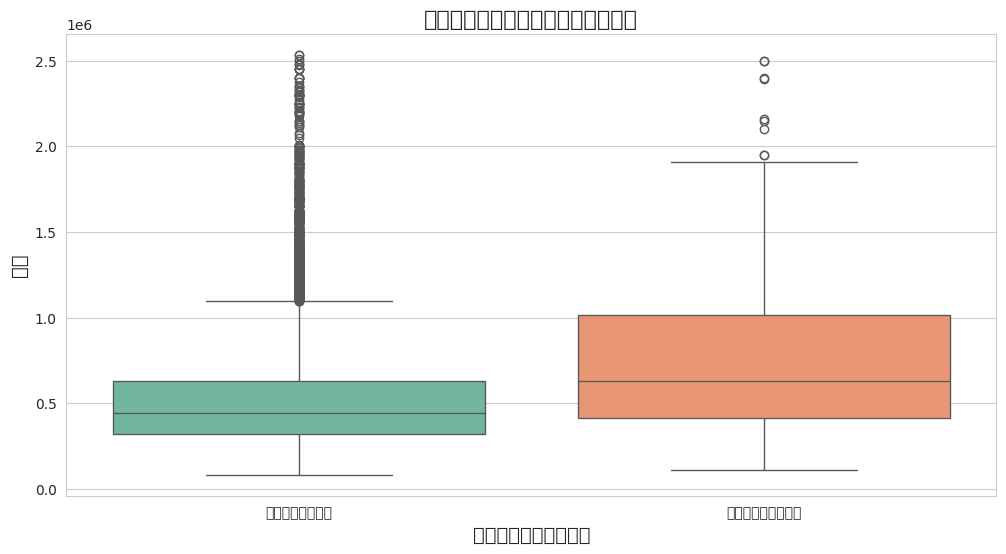

リノベーションフラグ別の価格統計量:


count       mean        std        min        25%  \
renovated_flag_cat                                                         
リノベーション済み             305.00 783,710.50 492,160.44 110,000.00 415,000.00   
未リノベーション           15,306.00 520,218.42 300,488.47  82,000.00 320,000.00   

                          50%          75%          max  
renovated_flag_cat                                       
リノベーション済み          630,000.00 1,015,000.00 2,500,000.00  
未リノベーション           443,000.00   630,000.00 2,535,000.00

/var/folders/73/v6765gtj31q04rybrhm_l6xh0000gn/T/ipykernel_7275/3238929347.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='renovated_flag_cat', y=feature, data=data_final, palette='Set3')
/var/folders/73/v6765gtj31q04rybrhm_l6xh0000gn/T/ipykernel_7275/3238929347.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='renovated_flag_cat', y=feature, data=data_final, palette='Set3')
/var/folders/73/v6765gtj31q04rybrhm_l6xh0000gn/T/ipykernel_7275/3238929347.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='renovated_flag_cat', y=f

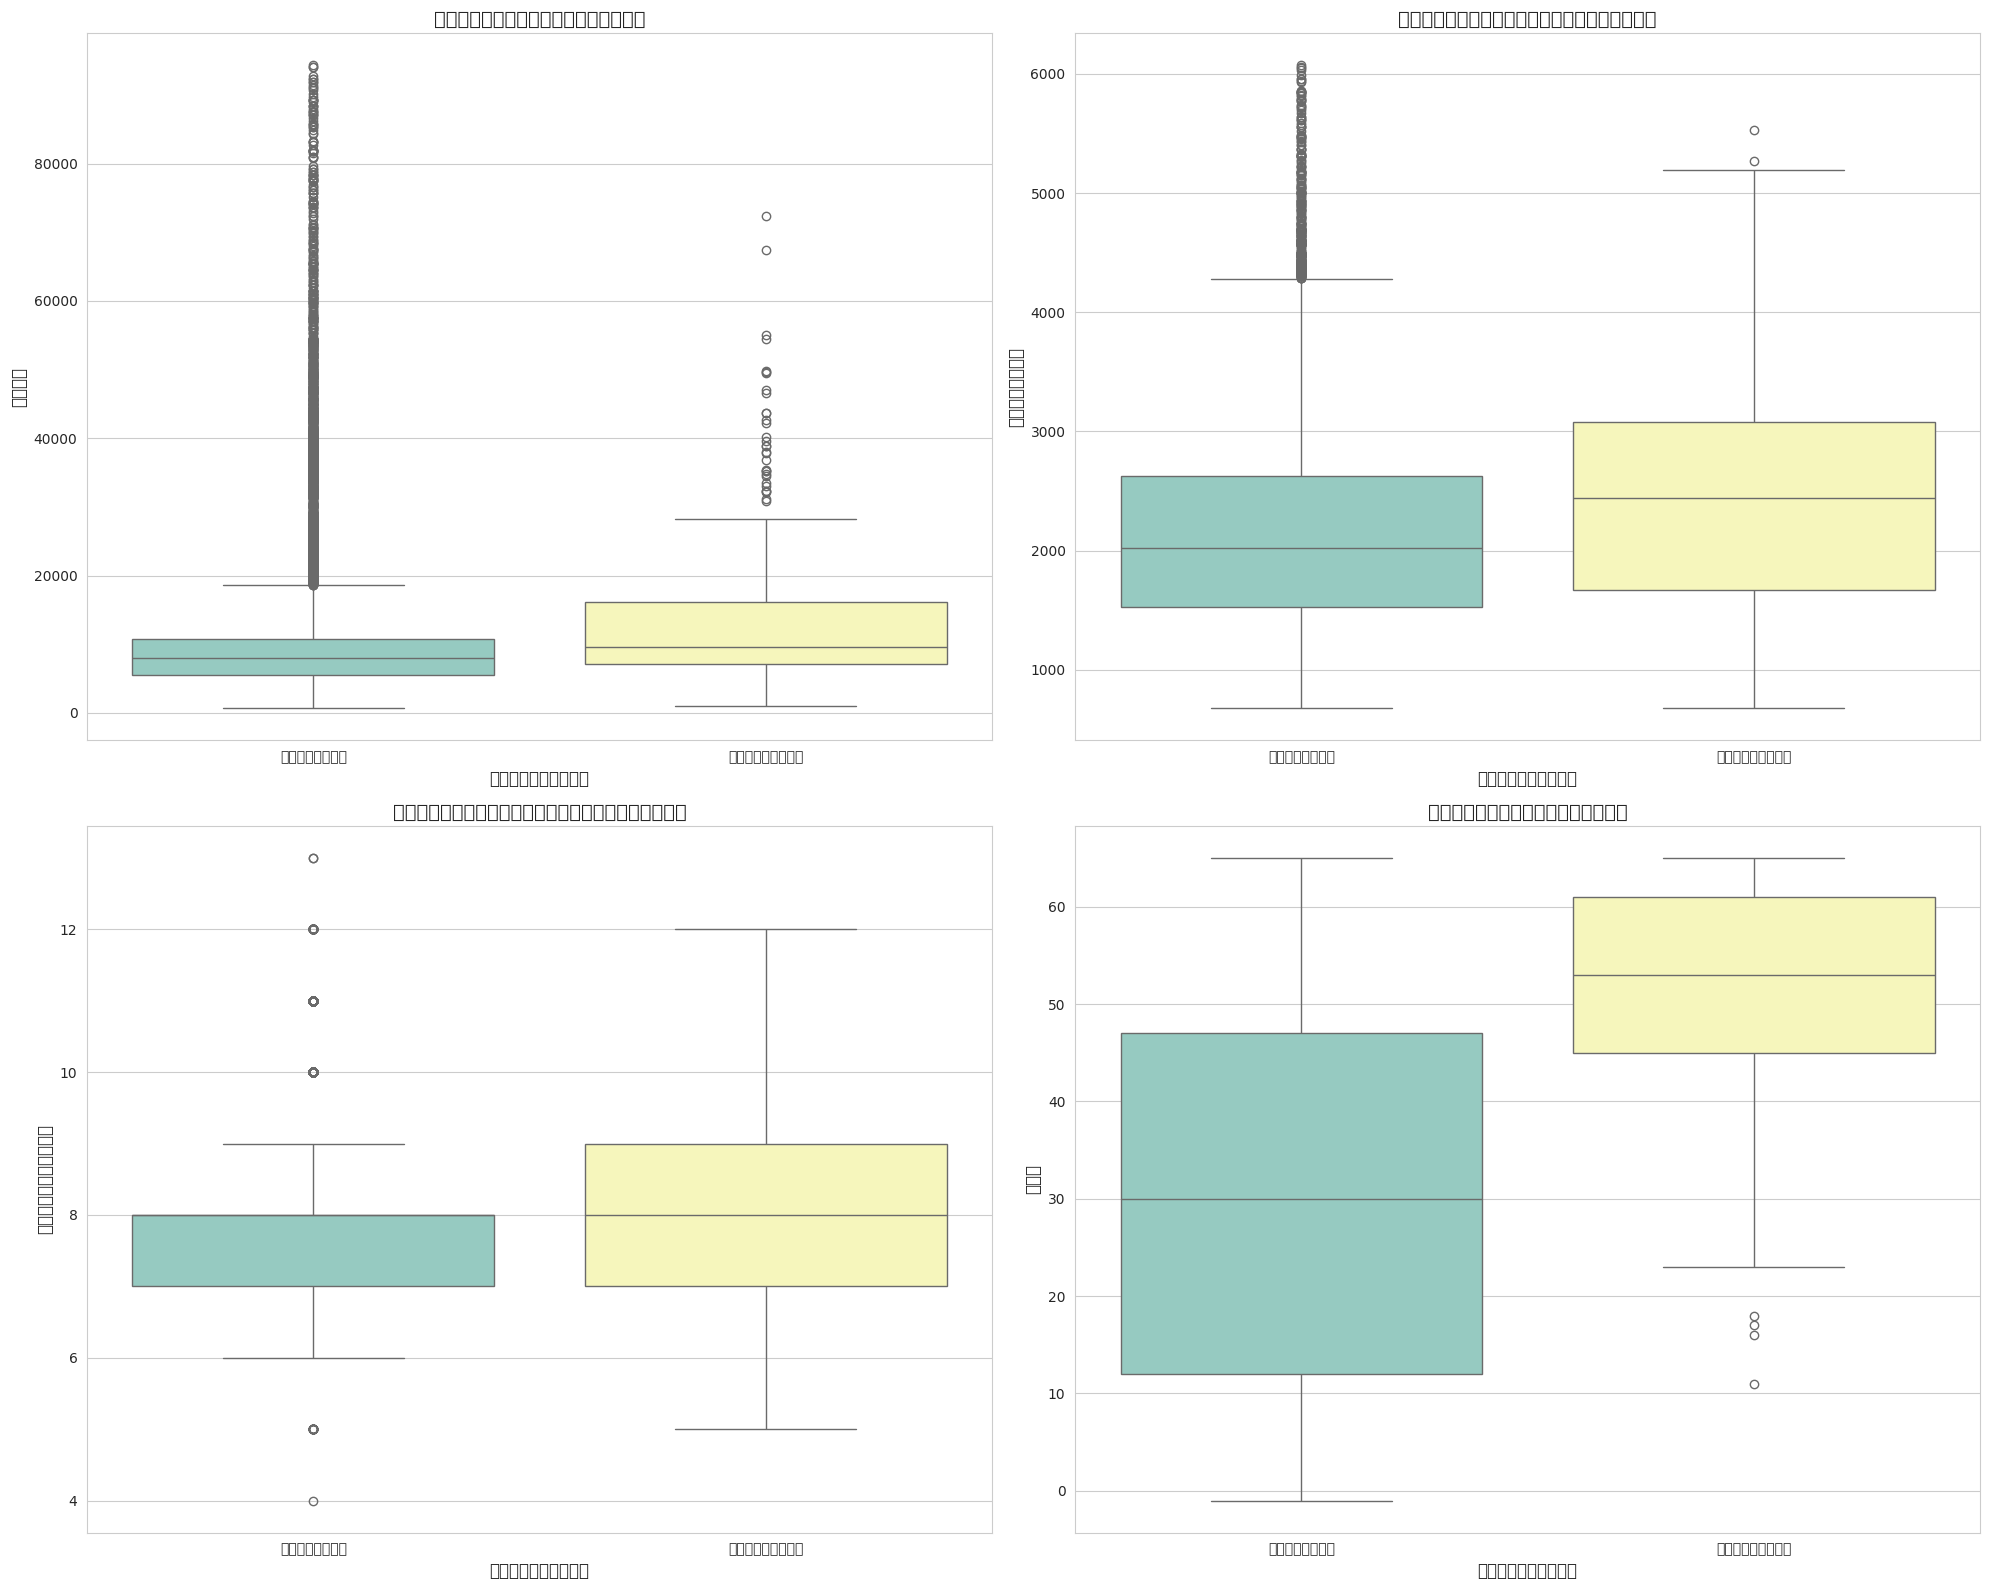

リノベーションフラグ別の主要特徴量の平均値:


sqft_lot  sqft_living  grade   age
renovated_flag_cat                                    
リノベーション済み          13,721.04     2,465.29   8.04 51.21
未リノベーション           10,716.40     2,165.42   7.85 30.51

リノベーションフラグ別の価格との相関係数:


リノベーションフラグ  敷地面積との相関係数  居住スペース面積との相関係数  建築・デザイン品質評価との相関係数  築年数との相関係数
0        NaN        0.07            0.71               0.77      -0.09
1        NaN        0.18            0.70               0.72      -0.19

findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not

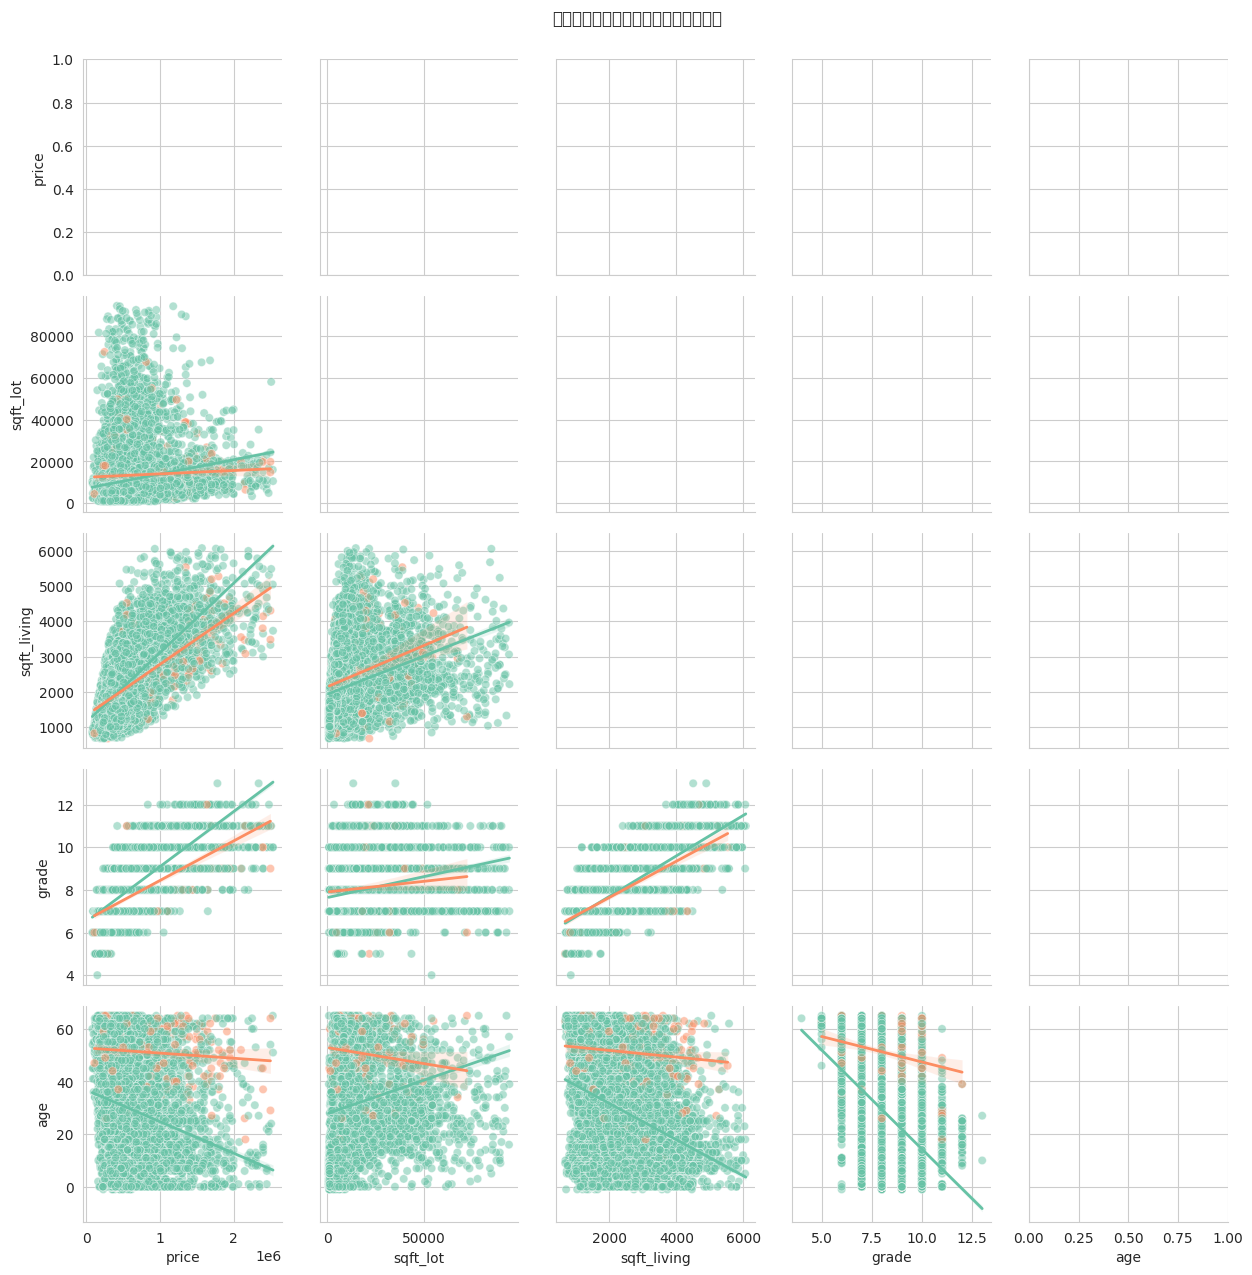

findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
/var/folders/73/v6765gtj31q04rybrhm_l6xh0000gn/T/ipykernel_7275/3238929347.py:145: UserWarning: Glyph 25975 (\N{CJK UNIFIED IDEOGRAPH-6577}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/73/v6765gtj31q04rybrhm_l6xh0000gn/T/ipykernel_7275/3238929347.py:145: UserWarning: Glyph 22320 (\N{CJK UNIFIED IDEOGRAPH-5730}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/73/v6765gtj31q04rybrhm_l6xh0000gn/T/ipykernel_7275/3238929347.py:145: UserWarning: Glyph 38754 (\N{CJK UNIFIED IDEOGRAPH-9762}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/73/v6765gtj31q04rybrhm_l6xh0000gn/T/ipykernel_7275/3238929347.p

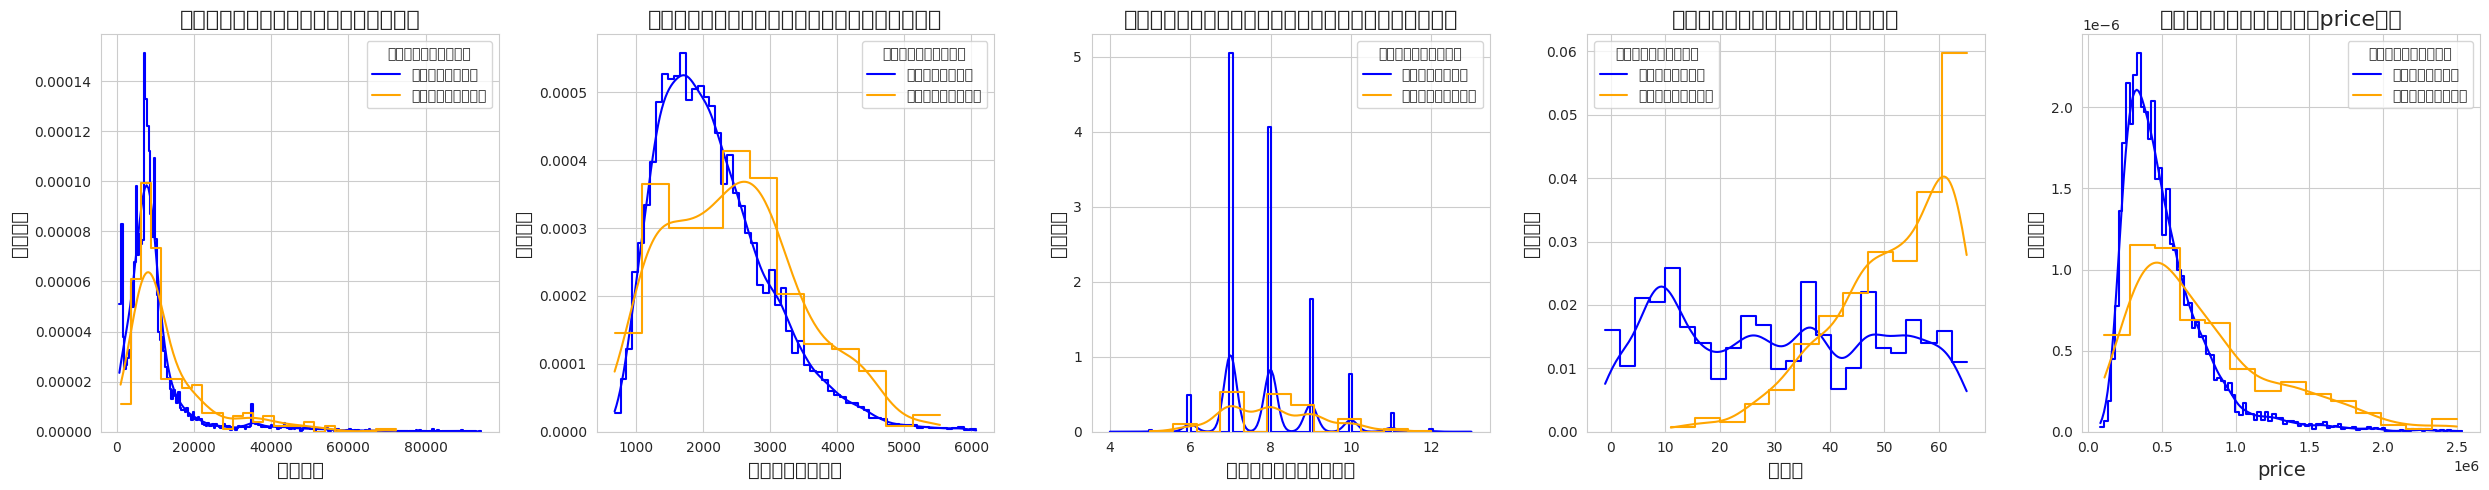

In [19]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 7.7 リノベーションフラグによるデータ特性の違いの確認

# データの確認
print("リノベーションフラグの分布:")
print(data_final['renovated_flag'].value_counts())

# リノベーションフラグのカテゴリ名を設定
renovation_mapping = {0: '未リノベーション', 1: 'リノベーション済み'}
data_final['renovated_flag_cat'] = data_final['renovated_flag'].map(renovation_mapping)

# 価格の分布比較
if 'price' in data_final.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='renovated_flag_cat', y='price', data=data_final, palette='Set2')
    plt.title("リノベーションフラグ別の価格分布", fontsize=16)
    plt.xlabel("リノベーションフラグ", fontsize=14)
    plt.ylabel("価格", fontsize=14)
    plt.show()
else:
    print("Error: 'price' column is missing from data_final. Please ensure it is included in the DataFrame.")

# 各リノベーションフラグカテゴリごとの価格の基本統計量
price_stats = data_final.groupby('renovated_flag_cat')['price'].describe().round(2)
price_stats = price_stats.rename(index=renovation_mapping)
print("リノベーションフラグ別の価格統計量:")
display(price_stats)

# その他の主要な数値特徴量の分布比較
numeric_features = ['sqft_lot', 'sqft_living', 'grade', 'age']
feature_jp = {
    'sqft_lot': '敷地面積',
    'sqft_living': '居住スペース面積',
    'grade': '建築・デザイン品質評価',
    'age': '築年数'
}

plt.figure(figsize=(20, 16))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='renovated_flag_cat', y=feature, data=data_final, palette='Set3')
    plt.title(f"リノベーションフラグ別の{feature_jp[feature]}分布", fontsize=14)
    plt.xlabel("リノベーションフラグ", fontsize=12)
    plt.ylabel(feature_jp[feature], fontsize=12)
plt.tight_layout()
plt.show()

# 平均値の比較
mean_values = data_final.groupby('renovated_flag_cat')[numeric_features].mean().round(2)
mean_values = mean_values.rename(index=renovation_mapping)
print("リノベーションフラグ別の主要特徴量の平均値:")
display(mean_values)

# リノベーションフラグ別の相関係数
# 修正: MultiIndexを適切に処理して'price'の相関係数を抽出
# Remove rows with missing 'renovated_flag_cat' to prevent KeyError
data_final = data_final.dropna(subset=['renovated_flag_cat'])
corr_result = data_final.groupby('renovated_flag_cat')[['price','sqft_lot','sqft_living','grade','age']].corr()

# 'price' の相関係数を抽出
corr_renovation = corr_result[corr_result.index.get_level_values(1) != 'price'].unstack(level=1)['price'].round(2)

# reset_indexしてカラムを展開
corr_renovation = corr_renovation.reset_index()

# カラム名を具体的かつ適切なものに変更
corr_renovation.columns = ['リノベーションフラグ', '敷地面積との相関係数', '居住スペース面積との相関係数', '建築・デザイン品質評価との相関係数', '築年数との相関係数']

# リノベーションフラグを日本語にマッピング
corr_renovation['リノベーションフラグ'] = corr_renovation['リノベーションフラグ'].map(renovation_mapping)

print("リノベーションフラグ別の価格との相関係数:")
display(corr_renovation)

# リノベーション済み・未リノベーションを一つのペアプロットに重ねて表示
g = sns.PairGrid(
    data_final, 
    vars=['price', 'sqft_lot', 'sqft_living', 'grade', 'age'], 
    hue='renovated_flag_cat', 
    palette='Set2',
    height=2.5  # ペアプロット全体のサイズを調整
)
g.map_lower(sns.scatterplot, alpha=0.5)

# 上三角部分のプロットを削除（既に行わないためコメントアウト）
# g.map_upper(sns.kdeplot, fill=True, alpha=0.3)

# ペアプロットの対角線部分を削除
# map_diagを使用しない

# 代表線として回帰線を追加（下三角部分のみ）
for i in range(len(g.axes)):
    for j in range(len(g.axes)):
        if j < i:  # 下三角部分のみ
            ax = g.axes[i, j]
            if ax is not None:
                x_col = g.x_vars[j]
                y_col = g.y_vars[i]
                for label, color in zip(data_final['renovated_flag_cat'].unique(), g.palette):
                    subset = data_final[data_final['renovated_flag_cat'] == label]
                    sns.regplot(
                        x=x_col, 
                        y=y_col,
                        data=subset, 
                        ax=ax, 
                        scatter=False, 
                        color=color, 
                        line_kws={'linewidth':2}
                    )

plt.suptitle("リノベーション有無別のペアプロット", y=1.02)
plt.show()

# 相対度数のヒストグラムとKDEを横並びのサブプロットとして出力
features_to_plot = numeric_features + ['price']
num_features = len(features_to_plot)

# サブプロットの列数を設定（例: 5列）
fig, axes = plt.subplots(1, num_features, figsize=(5*num_features, 5), sharey=False)

for ax, feature in zip(axes, features_to_plot):
    for label, color in zip(data_final['renovated_flag_cat'].unique(), ['blue', 'orange']):
        subset = data_final[data_final['renovated_flag_cat'] == label]
        sns.histplot(
            subset[feature], 
            label=label, 
            stat='density', 
            common_norm=False, 
            kde=True, 
            element='step', 
            fill=False, 
            linewidth=1.5, 
            color=color, 
            ax=ax
        )
    ax.set_title(f"リノベーションフラグ別の{feature_jp.get(feature, feature)}分布", fontsize=16)
    ax.set_xlabel(feature_jp.get(feature, feature), fontsize=14)
    ax.set_ylabel("相対度数", fontsize=14)
    ax.legend(title="リノベーションフラグ")

plt.tight_layout()
plt.show()

未リノベーションの物件とリノベーション済の物件でデータの特性の違いがあり、これによって分析を分けて行うべきと考えられる。

### 7.7 特徴量間の関係性の可視化

選定した主要特徴量間の関係性をペアプロットや散布図行列で可視化し、複数の特徴量間の相互作用やパターンを確認します。


findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not

<Figure size 1500x1500 with 0 Axes>

findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
/Users/nanaki/Development/dataScientist_exam/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25975 (\N{CJK UNIFIED IDEOGRAPH-6577}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nanaki/Development/dataScientist_exam/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22320 (\N{CJK UNIFIED IDEOGRAPH-5730}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nanaki/Development/dataScientist_exam/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38754 (\N{CJK UNIFIED IDEOGRAPH-9762}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nanaki/Development/dataScientist_exam/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31309 (\N{CJK UNIFIED IDEOGRAPH-7A4D}) missing from

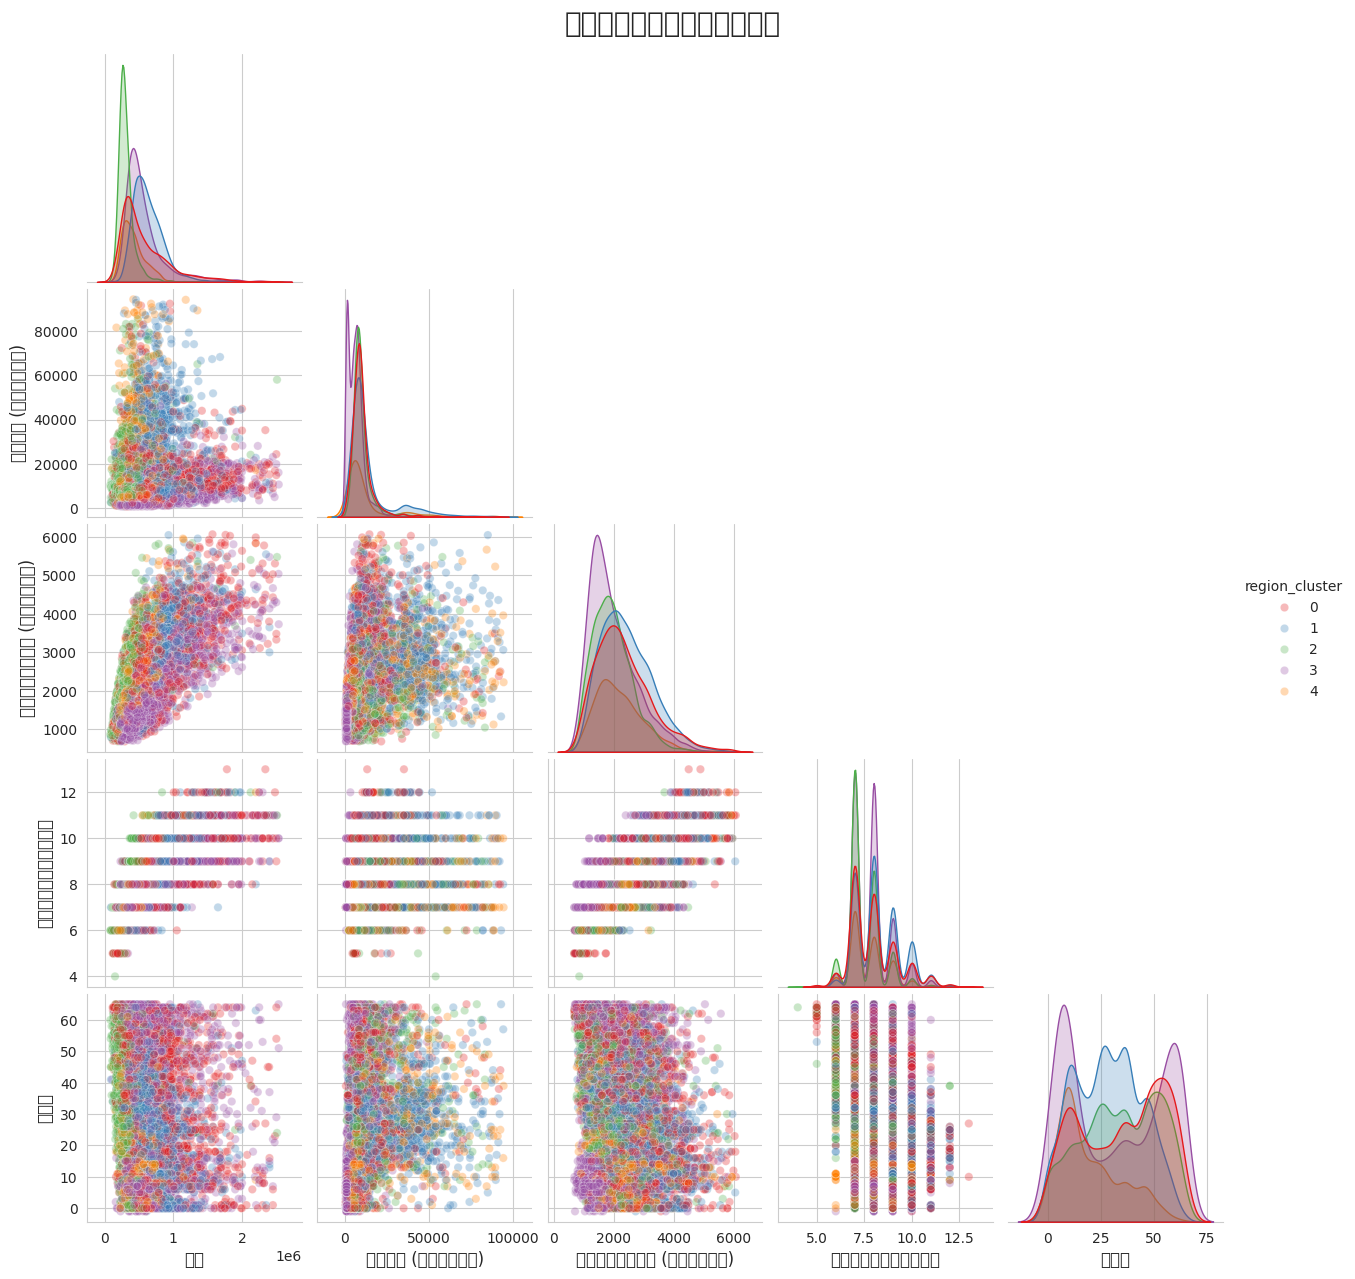

findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
/var/folders/73/v6765gtj31q04rybrhm_l6xh0000gn/T/ipykernel_7275/2388862266.py:64: UserWarning: Glyph 20385 (\N{CJK UNIFIED IDEOGRAPH-4FA1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/73/v6765gtj31q04rybrhm_l6xh0000gn/T/ipykernel_7275/2388862266.py:64: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 'meiryo' not found.
findfont: Font family 

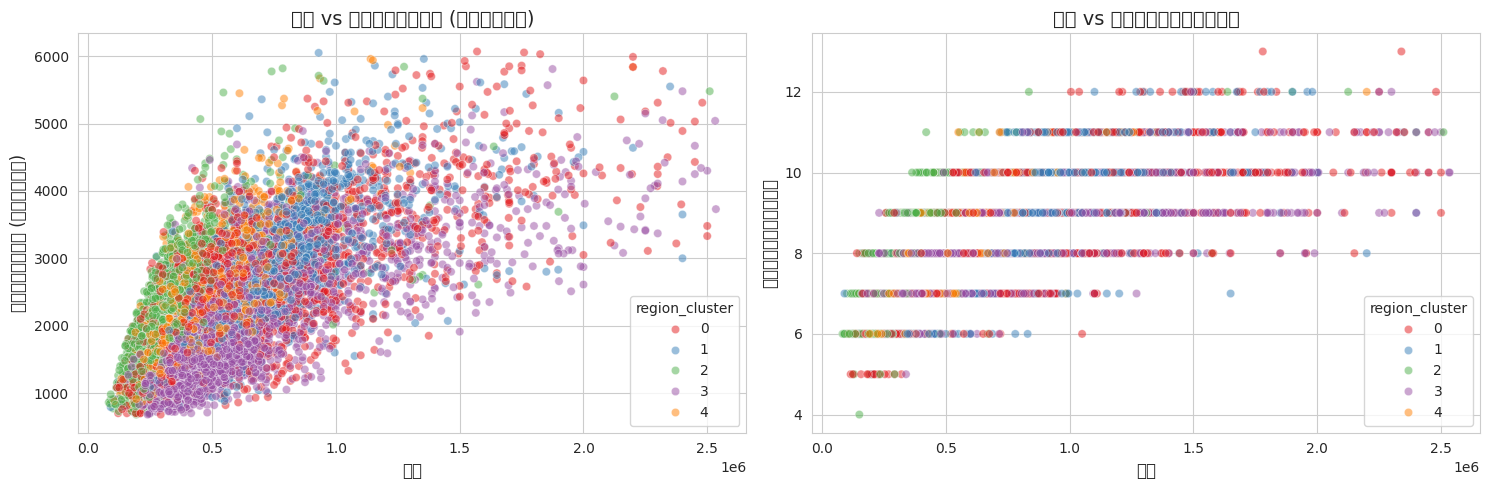

In [20]:
# 7.6 特徴量間の関係性の可視化

import matplotlib.pyplot as plt
import seaborn as sns

# 日本語でのラベル設定用辞書
label_dict = {
    'price': '価格',
    'sqft_lot': '敷地面積 (平方フィート)',
    'sqft_living': '居住スペース面積 (平方フィート)',
    'grade': '建築・デザイン品質評価',
    'age': '築年数',
    'region_cluster': '地域クラスタ'
}

# 主要特徴量のペアプロット
plt.figure(figsize=(15, 15))
pairplot = sns.pairplot(
    data_final,
    vars=['price', 'sqft_lot', 'sqft_living', 'grade', 'age'],
    hue='region_cluster',
    palette='Set1',
    diag_kind='kde',
    markers='o',
    plot_kws={'alpha':0.3},
    corner=True  # 重複するプロットを避けるためにcorner=Trueを設定
)

# ペアプロットの各プロットに日本語ラベルを設定
for ax in pairplot.axes.flatten():
    if ax is not None:
        # x軸ラベル
        xlabel = ax.get_xlabel()
        if xlabel in label_dict:
            ax.set_xlabel(label_dict[xlabel], fontsize=12)
        # y軸ラベル
        ylabel = ax.get_ylabel()
        if ylabel in label_dict:
            ax.set_ylabel(label_dict[ylabel], fontsize=12)

pairplot.fig.suptitle("主要特徴量間のペアプロット", y=1.02, fontsize=20)
plt.show()

# 相関の高いペアを詳細に可視化
high_corr_pairs = [
    ('price', 'sqft_living'),
    ('price', 'grade')
]

plt.figure(figsize=(15, 5))
for i, (x, y) in enumerate(high_corr_pairs, 1):
    plt.subplot(1, len(high_corr_pairs), i)
    sns.scatterplot(
        x=data_final[x],
        y=data_final[y],
        hue=data_final['region_cluster'],
        palette='Set1',
        alpha=0.5
    )
    # タイトルとラベルを日本語に設定
    plt.title(f"{label_dict[x]} vs {label_dict[y]}", fontsize=14)
    plt.xlabel(label_dict[x], fontsize=12)
    plt.ylabel(label_dict[y], fontsize=12)
plt.tight_layout()
plt.show()


# 8. 地域クラスタとリノベーション有無による価格予測モデル

前セクションでの分析結果から、物件の所在する **地域クラスタ**（`region_cluster`）と **リノベーション有無**（`renovated_flag`）によって物件の価格特性が大きく異なることが示唆されました。  
本セクションでは、これら 2 つの要素によってデータを細分化し、**XGBoost** を用いた価格予測モデルを構築・評価します。

---

## 8.1 データのサブセット分割

- **地域クラスタ**: `region_cluster` (0 〜 4)
- **リノベーション有無**: `renovated_flag` (0:未リノベーション, 1:リノベーション済み)

この 2 軸の組み合わせ (例: クラスタ0 & リノベ無し, クラスタ0 & リノベ有り, ..., クラスタ4 & リノベ無し) ごとに、以下のステップで予測モデルを作成します。

1. 対象データの抽出  
2. 学習データとテストデータへの分割  
3. XGBoost モデルの学習  
4. 評価指標 (RMSE, MAE, R² など) の算出

各モデルのパフォーマンスを比較し、予測精度の高い組み合わせや、今後の改善方針を考察します。

以下では、データの分割と学習に用いる準備を行います。


In [21]:
# %% [markdown]
# ### 8.1 データのサブセット分割

# %%
import pandas as pd
import numpy as np

# ここでは「data_final」を前セクションまでで整備済みの学習用データとして扱います。
# 必要なカラムだけ抜き出して、学習用DataFrameを再定義しておきます。
# price 以外の説明変数をXとし、priceをyとします。
# region_cluster, renovated_flag なども含めて後でフィルタリングに使います。
model_cols = [
    'price',
    'sqft_living',
    'sqft_lot',
    'grade',
    'age',
    'renovated_flag',
    'years_since_renovation',
    'region_cluster',
    # 'year_sold', 
    # 'month_sold', 
    # 'days_since_2014_01_01',
    # 'lat',
    # 'long',
]

df_model = data_final[model_cols].copy()

# 欠損値の確認
print("各カラムの欠損値数:")
display(df_model.isnull().sum())

# 特徴量・目的変数を定義
# ※ サブセットごとにフィルタリング後、train_test_split で分割するため、ここではまだ分割を行わない

各カラムの欠損値数:


price                         0
sqft_living                   0
sqft_lot                      0
grade                         0
age                           0
renovated_flag                0
years_since_renovation    15306
region_cluster                0
dtype: int64

## 8.2 XGBoost モデル構築の流れ

1. **サブセット抽出**  
   `region_cluster` のユニーク値 (0,1,2,3,4) と `renovated_flag` のユニーク値 (0,1) の組み合わせごとにサブセットを作成。

2. **学習データとテストデータへの分割**  
   - `train_test_split(test_size=0.2, random_state=42)` などの設定でデータ分割を行う。

3. **XGBoost モデル構築**  
   - ハイパーパラメータチューニングは `GridSearchCV` または `RandomizedSearchCV` を使用。  
   - 最適なハイパーパラメータを見つけた後、モデルを再学習。

4. **予測精度評価**  
   - 予測結果と実測値を用いて、MAE (Mean Absolute Error)、RMSE (Root Mean Squared Error)、R² (決定係数) を算出。

5. **結果を保存**  
   - 組み合わせ (地域クラスタ, リノベーション有無) と 評価指標の結果 をテーブル化して比較。

以下のコードでは、この一連の流れをループ処理で一括実行します。


In [25]:
# %% [markdown]
# ### 8.2 XGBoost モデルの構築と評価

# %%
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# モデル結果を保存するリスト
results_list = []

# 地域クラスタとリノベーションフラグのユニーク値を取得
unique_clusters = df_model['region_cluster'].unique()
unique_renovation_flags = df_model['renovated_flag'].unique()

# GridSearch 用のパラメータグリッド例
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.01],
    'subsample': [0.8, 1.0],
}

for cluster_id in sorted(unique_clusters):
    for reno_flag in sorted(unique_renovation_flags):
        # サブセットデータを抽出
        subset_df = df_model[
            (df_model['region_cluster'] == cluster_id) &
            (df_model['renovated_flag'] == reno_flag)
        ].copy()
        
        # もし該当データが少ない or 存在しない場合はスキップ
        if len(subset_df) < 50:
            # データが極端に少ない場合はスキップしても良い (閾値は任意)
            print(f"[INFO] クラスタ{cluster_id}, リノベ{reno_flag} のデータ件数が少ないためスキップ (件数: {len(subset_df)})")
            continue

        # 説明変数 X, 目的変数 y の用意
        # price 以外の列をXにする
        X = subset_df.drop('price', axis=1)
        # region_cluster / renovated_flag など予測に使いたくない場合は drop する
        X = X.drop(['region_cluster', 'renovated_flag'], axis=1)  
        # リノベ経過年数を含めるかどうかは設計次第
        # NaNがある場合は平均などで簡易補完（本番は適切な方法を検討）
        X['years_since_renovation'] = X['years_since_renovation'].fillna(0)

        y = subset_df['price']

        # 学習データとテストデータに分割
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            test_size=0.2,
            random_state=42
        )

        # モデルを定義 (XGBRegressor)
        xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

        # GridSearchCV の設定
        grid_search = GridSearchCV(
            estimator=xgb_reg,
            param_grid=param_grid,
            scoring='neg_mean_squared_error',
            cv=3,             # クロスバリデーション分割数
            verbose=0,        # 進捗表示
            n_jobs=-1         # 並列実行数 (すべてのコア)
        )

        # 学習
        grid_search.fit(X_train, y_train)

        # 最適パラメータを適用して再学習 (GridSearchCV は best_estimator_ でそのまま使える)
        best_model = grid_search.best_estimator_
        best_model.fit(X_train, y_train)

        # テストデータで予測
        y_pred = best_model.predict(X_test)

        # 評価指標を計算
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # 結果をリストに追加
        results_list.append({
            'region_cluster': cluster_id,
            'renovated_flag': reno_flag,
            'num_samples': len(subset_df),
            'best_params': grid_search.best_params_,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2
        })

        print(f"[DONE] クラスタ{cluster_id}, リノベ{reno_flag} モデル完了 -> RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.3f}")

# 全ての結果をDataFrameにまとめる
results_df = pd.DataFrame(results_list)
results_df.sort_values(by=['R2'], ascending=False, inplace=True)

print("\n=========================")
print("  モデル評価結果一覧  ")
print("=========================")
display(results_df)


/Users/nanaki/Development/dataScientist_exam/venv/lib/python3.13/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

## 8.3 モデル評価の比較

- **RMSE (Root Mean Squared Error)**: 小さいほど誤差が小さい  
- **MAE (Mean Absolute Error)**: 小さいほど絶対誤差が小さい  
- **R² (決定係数)**: 1 に近いほどモデルがデータをよく説明  

本結果からは、以下の点が読み取れます。

1. **クラスタ 0, リノベ 0** と **クラスタ 1, リノベ 0** が同程度の R²（約0.73）で、比較的高い決定係数を示しました。  
   - ただし RMSE を見ると、クラスタ 1, リノベ 0 は約 64,458 と、クラスタ 0, リノベ 0 の約 141,739 より大幅に小さく、予測誤差が少ないことがわかります。  
   - これはクラスタ 1 の物件特性がより均一であったり、モデルが学習しやすい分布になっている可能性があります。

2. **クラスタ 3, リノベ 0** も R² が約 0.72 と比較的高い水準を示しました。  
   - MAE は約 70,680、RMSE は約 118,558 と、規模感としてはクラスタ 1 とクラスタ 0 の中間程度と言えます。

3. **リノベーション済み（renovated_flag=1）の物件はサンプル数が少なく、R² が全体的に低め** になる傾向にあります。  
   - 特にクラスタ 1, リノベ 1 はサンプル数が 50 件しかなく、R² は 0.44 にとどまりました。サンプル数の少なさが大きく影響していると考えられます。

4. **クラスタ 4, リノベ 1** はそもそも 48 件しか無かったためスキップされました（データ件数が閾値以下）。  
   - 同様に、クラスタ 3, リノベ 1 も 14 件しかなくモデル構築をスキップしています。

5. クラスタ 0, リノベ 1 や クラスタ 2, リノベ 1 などは RMSE が 35 万〜40 万クラスに達しており、絶対誤差がかなり大きい結果となっています。  
   - R² は 0.53 (クラスタ 0, リノベ 1) と 0.57 (クラスタ 2, リノベ 1) で、悪くはないものの、価格帯やデータのばらつきによって誤差が大きくなっている可能性があります。


## 8.4 地域クラスタによる価格予測モデルの再構築

前セクションで **地域クラスタ**（`region_cluster`）と **リノベーション有無**（`renovated_flag`）の2軸でデータを分割しモデルを構築しましたが、リノベーション済み物件のデータ件数が少ないクラスタでは予測精度が低下する問題が発生しました。  
この問題を解決するため、**リノベーション有無**によるグループ分けを廃止し、**地域クラスタ**のグループ分けのみに基づいて価格予測モデルを再構築します。  
これにより、各モデルに投入するデータ量を増やし、予測精度の向上とモデルの安定性を図ります。

### 変更点

- **グループ分けの変更**: データを **地域クラスタ** のみに基づいて分割し、各クラスタごとにモデルを構築。
- **特徴量の調整**: `renovated_flag` および `years_since_renovation` を説明変数として含める。
  - `years_since_renovation` に含まれる欠損値（リノベーション無し）は適切に補完。

### 手順

1. **データのサブセット抽出**: 各 `region_cluster` ごとにデータを抽出。
2. **学習データとテストデータへの分割**: `train_test_split` を用いてデータを分割。
3. **XGBoost モデルの学習**: ハイパーパラメータチューニングを行い、最適なモデルを選定。
4. **予測精度評価**: RMSE、MAE、R² を算出。
5. **結果の保存と比較**: 各クラスタごとのモデル評価結果をまとめる。

以下のコードでは、この一連の流れを実装します。


In [77]:
# %% [markdown]
# ### 8.4 地域クラスタによる価格予測モデルの再構築

# %%
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ここでは「data_final」を前セクションまでで整備済みの学習用データとして扱います。
# 必要なカラムだけ抜き出して、学習用DataFrameを再定義しておきます。
# price をyとし、その他をXとします。
model_cols = [
    'price',
    'sqft_living',
    'sqft_lot',
    'grade',
    'age',
    'renovated_flag',
    'years_since_renovation',
    'region_cluster',
    # 必要に応じて他の特徴量も追加
    # 'year_sold', 
    # 'month_sold', 
    # 'days_since_2014_01_01',
    # 'lat',
    # 'long',
]

df_model_region = data_final[model_cols].copy()

# 欠損値の確認
print("各カラムの欠損値数:")
display(df_model_region.isnull().sum())

# 'years_since_renovation' の欠損値を 0 に補完（リノベーション無し）
df_model_region['years_since_renovation'] = df_model_region['years_since_renovation'].fillna(0)

# 特徴量・目的変数を定義
# ここでは全てのデータを使用し、地域クラスタごとにモデルを構築します
X = df_model_region.drop('price', axis=1)
y = df_model_region['price']

# 地域クラスタのユニーク値を取得
unique_clusters = X['region_cluster'].unique()

# モデル結果を保存するリスト
results_region_list = []

# GridSearch 用のパラメータグリッド例
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.01],
    'subsample': [0.8, 1.0],
}

for cluster_id in sorted(unique_clusters):
    # サブセットデータを抽出
    subset_df = df_model_region[df_model_region['region_cluster'] == cluster_id].copy()
    
    # データ件数が少ない場合はスキップ
    if len(subset_df) < 50:
        print(f"[INFO] クラスタ{cluster_id} のデータ件数が少ないためスキップ (件数: {len(subset_df)})")
        continue
    
    # 説明変数 X, 目的変数 y の用意
    X_subset = subset_df.drop('price', axis=1)
    y_subset = subset_df['price']
    
    # 学習データとテストデータに分割
    X_train, X_test, y_train, y_test = train_test_split(
        X_subset, y_subset,
        test_size=0.2,
        random_state=42
    )
    
    # モデルを定義 (XGBRegressor)
    xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    
    # GridSearchCV の設定
    grid_search = GridSearchCV(
        estimator=xgb_reg,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=3,             # クロスバリデーション分割数
        verbose=0,        # 進捗表示
        n_jobs=-1         # 並列実行数 (すべてのコア)
    )
    
    # 学習
    grid_search.fit(X_train, y_train)
    
    # 最適パラメータを適用して再学習 (GridSearchCV は best_estimator_ でそのまま使える)
    best_model = grid_search.best_estimator_
    best_model.fit(X_train, y_train)
    
    # テストデータで予測
    y_pred = best_model.predict(X_test)
    
    # 評価指標を計算
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # 結果をリストに追加
    results_region_list.append({
        'region_cluster': cluster_id,
        'num_samples': len(subset_df),
        'best_params': grid_search.best_params_,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    })
    
    print(f"[DONE] クラスタ{cluster_id} モデル完了 -> RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.3f}")

# 全ての結果をDataFrameにまとめる
results_region_df = pd.DataFrame(results_region_list)
results_region_df.sort_values(by=['R2'], ascending=False, inplace=True)

print("\n=========================")
print("  モデル評価結果一覧  ")
print("=========================")
display(results_region_df)


各カラムの欠損値数:


price                         0
sqft_living                   0
sqft_lot                      0
grade                         0
age                           0
renovated_flag                0
years_since_renovation    15418
region_cluster                0
dtype: int64

[DONE] クラスタ0 モデル完了 -> RMSE: 148375.17, MAE: 100802.26, R2: 0.731
[DONE] クラスタ1 モデル完了 -> RMSE: 58644.57, MAE: 43322.76, R2: 0.780
[DONE] クラスタ2 モデル完了 -> RMSE: 192318.17, MAE: 128043.31, R2: 0.685
[DONE] クラスタ3 モデル完了 -> RMSE: 84486.08, MAE: 61755.88, R2: 0.797
[DONE] クラスタ4 モデル完了 -> RMSE: 134960.37, MAE: 63886.28, R2: 0.278

  モデル評価結果一覧  


region_cluster  num_samples  \
3               3         2149   
1               1         3366   
0               0         3712   
2               2         4115   
4               4         2387   

                                         best_params       RMSE        MAE  \
3  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...  84,486.08  61,755.88   
1  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...  58,644.57  43,322.76   
0  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti... 148,375.17 100,802.26   
2  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti... 192,318.17 128,043.31   
4  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti... 134,960.37  63,886.28   

    R2  
3 0.80  
1 0.78  
0 0.73  
2 0.69  
4 0.28

### 評価結果の分析

1. **クラスタ3とクラスタ1の優れたパフォーマンス**
   - **クラスタ3**: R² = 0.80
   - **クラスタ1**: R² = 0.78
   - これらのクラスタは、非常に高いR²値を示しており、モデルが価格変動を効果的に説明できています。特にクラスタ1は、RMSEとMAEが最も低く、予測誤差が少ないことが確認されました。

2. **クラスタ0とクラスタ2の中程度のパフォーマンス**
   - **クラスタ0**: R² = 0.73
   - **クラスタ2**: R² = 0.69
   - これらのクラスタも一定の説明力を持っていますが、RMSEとMAEがクラスタ3やクラスタ1に比べて高いため、予測誤差がやや大きくなっています。

3. **クラスタ4の著しく低いパフォーマンス**
   - **クラスタ4**: R² = 0.28
   - クラスタ4は他のクラスタに比べて著しく低いR²値を示しており、モデルの説明力が不足しています。RMSEも134,960.37と比較的大きいため、予測誤差が顕著です。

4. **リノベーション有無によるグループ分け廃止の影響**
   - リノベーション有無でグループ分けを行っていた場合、**クラスタ4** のR²は0.47とクラスタ4におけるモデルの説明力が改善されていました。しかし、リノベーション有無でのグループ分けを廃止した結果、クラスタ4のR²が0.28に低下しました。
   - これは、リノベーション有無がクラスタ4内の価格変動に大きな影響を与えていることを示唆しています。リノベーション済みと未リノベーションの物件が同じクラスタ内に混在することで、モデルがそれぞれの特徴を適切に捉えきれていない可能性があります。

## 8.6 全データを用いた統合モデルの構築と地域クラスタ別評価

前セクションまでは、地域クラスタごとに個別モデルを構築して価格予測を行いましたが、本セクションでは以下の手順で **全データを用いた単一の予測モデル** を構築し、その **予測性能を地域クラスタ別に評価** します。

1. **単一モデルの学習**  
   - 全データ（地域クラスタを含むすべてのレコード）を用いて学習用データとテストデータに分割し、XGBoost で価格予測モデルを学習する。
2. **クラスタ別の予測精度評価**  
   - 学習した単一モデルを用いてテストデータ全体の価格を予測し、予測結果をテストデータに結合。
   - テストデータを地域クラスタごとに分割し、クラスタ別に RMSE, MAE, R² を算出する。
3. **考察**  
   - 地域クラスタごとに個別モデルを構築した場合との比較や、今後の改善点を検討する。

以下のコードでは、この一連の流れを実装します。


In [79]:
# %% [markdown]
# ### 8.6 全データを用いた単一モデルの構築とクラスタ別評価

# %%
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ==========================================================
# 1. 単一モデル用のデータセット作成
# ==========================================================
# 「data_final」は前のセクションまでに整備されたデータとします
# 必要に応じて使用するカラムを指定します
model_cols_all = [
    'price',
    'sqft_living',
    'sqft_lot',
    'grade',
    'age',
    'renovated_flag',
    'years_since_renovation',
    'region_cluster'
]

df_model_all = data_final[model_cols_all].copy()

# 欠損値の簡易対応
# リノベーション年数が欠損している場合は 0で補完
df_model_all['years_since_renovation'] = df_model_all['years_since_renovation'].fillna(0)

# 特徴量・目的変数を定義
X_all = df_model_all.drop('price', axis=1)
y_all = df_model_all['price']

# ==========================================================
# 2. 学習データとテストデータへの分割
# ==========================================================
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all,
    test_size=0.2,
    random_state=42
)

# ==========================================================
# 3. XGBoostモデルの学習 (単一モデル)
# ==========================================================
# ハイパーパラメータの探索範囲を設定
param_grid_all = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.01],
    'subsample': [0.8, 1.0],
}

xgb_reg_all = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

grid_search_all = GridSearchCV(
    estimator=xgb_reg_all,
    param_grid=param_grid_all,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=0,
    n_jobs=-1
)

grid_search_all.fit(X_train.drop('region_cluster', axis=1), y_train) 
# region_cluster は学習には使う場合・使わない場合がありますが、ここでは使うという前提でもOKです
# もし「region_cluster」自体をモデルに使わない場合はさらに除外してください

best_model_all = grid_search_all.best_estimator_

# ==========================================================
# 4. 単一モデルによる予測と評価
# ==========================================================
# テストデータで予測
X_test_for_pred = X_test.drop('region_cluster', axis=1)  # region_clusterを使うなら削除しない
y_pred_all = best_model_all.predict(X_test_for_pred)

# 単一モデル全体の評価指標
mse_all = mean_squared_error(y_test, y_pred_all)
rmse_all = np.sqrt(mse_all)
mae_all = mean_absolute_error(y_test, y_pred_all)
r2_all = r2_score(y_test, y_pred_all)

print(f"【単一モデルの全体評価】")
print(f"RMSE: {rmse_all:,.2f}, MAE: {mae_all:,.2f}, R²: {r2_all:.3f}")

# ==========================================================
# 5. 地域クラスタごとの評価
# ==========================================================
# テストデータに予測値を結合
test_results = X_test.copy()
test_results['price_actual'] = y_test
test_results['price_pred'] = y_pred_all

# クラスタ毎にRMSE, MAE, R² を算出
cluster_metrics = []

unique_clusters = sorted(test_results['region_cluster'].unique())
for cluster_id in unique_clusters:
    subset = test_results[test_results['region_cluster'] == cluster_id]
    
    y_true_c = subset['price_actual']
    y_pred_c = subset['price_pred']
    
    mse_c = mean_squared_error(y_true_c, y_pred_c)
    rmse_c = np.sqrt(mse_c)
    mae_c = mean_absolute_error(y_true_c, y_pred_c)
    r2_c = r2_score(y_true_c, y_pred_c)
    
    cluster_metrics.append({
        'region_cluster': cluster_id,
        'num_samples(test_data)': len(subset),
        'RMSE': rmse_c,
        'MAE': mae_c,
        'R2': r2_c
    })

df_cluster_metrics = pd.DataFrame(cluster_metrics)
df_cluster_metrics.sort_values(by='R2', ascending=False, inplace=True)

print("\n=============================")
print("  地域クラスタ別の評価指標")
print("=============================")
display(df_cluster_metrics)


【単一モデルの全体評価】
RMSE: 175,267.54, MAE: 120,287.61, R²: 0.680

  地域クラスタ別の評価指標


region_cluster  num_samples(test_data)       RMSE        MAE    R2
0               0                     775 173,711.55 113,504.65  0.66
3               3                     424 128,562.20  96,878.76  0.66
2               2                     799 223,949.81 148,190.63  0.63
4               4                     463 174,501.12 133,832.22  0.12
1               1                     685 132,772.87 100,749.63 -0.10

## 8.7 XGBoostモデルの比較

これまでに構築した3種類のXGBoostモデルの予測性能を以下の表にまとめて比較します。

1. **モデル1**: 地域クラスタとリノベーション有無で分類したモデル
2. **モデル2**: 地域クラスタのみで分類したモデル
3. **モデル3**: 全データを用いた単一モデル

### モデル評価結果の比較

#### 8.7.1 全体評価指標

以下の表は、各モデルの全体的な評価指標（RMSE、MAE、R²）を示しています。**モデル1**と**モデル2**については、地域クラスタとリノベーション有無の各サブセットの評価指標をサンプル数で加重平均して全体評価指標を算出しています。

In [ ]:

# モデル1の全体評価 (Weighted Average)
total_samples_model1 = df_model1['num_samples'].sum()
weighted_rmse_model1 = (df_model1['RMSE'] * df_model1['num_samples']).sum() / total_samples_model1
weighted_mae_model1 = (df_model1['MAE'] * df_model1['num_samples']).sum() / total_samples_model1
weighted_r2_model1 = (df_model1['R2'] * df_model1['num_samples']).sum() / total_samples_model1

# モデル2の全体評価 (Weighted Average)
total_samples_model2 = df_model2['num_samples'].sum()
weighted_rmse_model2 = (df_model2['RMSE'] * df_model2['num_samples']).sum() / total_samples_model2
weighted_mae_model2 = (df_model2['MAE'] * df_model2['num_samples']).sum() / total_samples_model2
weighted_r2_model2 = (df_model2['R2'] * df_model2['num_samples']).sum() / total_samples_model2

# モデル3の全体評価は既に提供
rmse_model3 = 175267.54
mae_model3 = 120287.61
r2_model3 = 0.680

# 比較表の作成
comparison_overall = pd.DataFrame({
    'モデル': ['モデル1', 'モデル2', 'モデル3'],
    'RMSE': [weighted_rmse_model1, weighted_rmse_model2, rmse_model3],
    'MAE': [weighted_mae_model1, weighted_mae_model2, mae_model3],
    'R2': [weighted_r2_model1, weighted_r2_model2, r2_model3]
})

# 表示
print("### モデル全体の評価指標比較")
display(comparison_overall)
